# Predicting FIFA World Cup Results

# Part 1 - Introduction

The purpose of this notebook is to select, train, validate and test a model to predict the results of the 2022 Qatar World Cup. It is divided in 7 parts:

1. Introduction
2. Data Import
3. Data Transformation & Exploration
4. Methodology Overview
5. Model Training and Validation
6. Results
7. Final Predictions on Test Set

## Imports

We start by importing all relevant packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from statistics import mean, stdev

from os import chdir
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve, classification_report, ConfusionMatrixDisplay, auc

# Part 2 - Data import

## Training data - International match history dataset

The International Match History Dataset compiles football match results between national teams between 2004-09-03 and 2021-12-18.

The dataset contains data from 5,641 matches with 25 features:

1. Date
2. Home team (HT)
3. Away team (AT)
4. HT continent
5. AT continent
6. HT FIFA rank
7. AT FIFA rank
8. HT total FIFA points
9. AT total FIFA points
10. HT score
11. AT score
12. Tournament
13. City
14. Country
15. Neutral location
16. Shoot out
17. HT result
18. HT goalkeeper score
19. AT goalkeeper score
20. HT defense score
21. HT offense score
22. HT midfield score
23. AT defense score
24. AT offense score
25. AT midfield score

In [2]:
# changing directory to current working directory
import os 
chdir(os.getcwd())

# reading raw .csv file
data = pd.read_csv('dataset/match_history.csv')

# date is imported as string, we change to datetime for easier cleaning
data['date'] = pd.to_datetime(data['date']).dt.date

In [3]:
# visualising first 5 rows
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8


## Testing data - Test set

The Test Set compiles football match results for 2022.

The dataset contains data from 247 matches with 4 features:

1. Date
2. Home team (HT)
3. Away team (AT)
4. HT result

In [4]:
test_data = pd.read_csv('dataset/test_set.csv')
test_data['date'] = pd.to_datetime(test_data['date']).dt.date

test_data.head()

,date,home_team,away_team,home_team_result
0,2022-01-02,Gabon,Burkina Faso,Lose
1,2022-01-05,Algeria,Ghana,Win
2,2022-01-09,Cameroon,Burkina Faso,Win
3,2022-01-10,Senegal,Zimbabwe,Win
4,2022-01-10,Morocco,Ghana,Win


We also load external data to help us with feature engineering later on.

In [5]:
# Load international matches dataset, only for 2022 onwards
international_matches = pd.read_csv('dataset/international_matches.csv')
international_matches['date'] = pd.to_datetime(international_matches['date']).dt.date

ref_date = dt.date(2022, 1, 1)
international_matches.drop(international_matches[international_matches['date'] < ref_date].index, inplace=True)

## Prediction data - World Cup 2022

The Test Set compiles the matches for the 2022 Qatar World Cup.

The dataset contains data from 48 matches with 3 features:

1. Date
2. Home team (HT)
3. Away team (AT)

In [6]:
pred_data = pd.read_csv('dataset/worldcup_2022.csv')
pred_data['date'] = pd.to_datetime(pred_data['date']).dt.date

# save a copy to print output
pred_output = pred_data

pred_data.head()

,date,home_team,away_team
0,2022-11-20,Qatar,Ecuador
1,2022-11-21,Senegal,Netherlands
2,2022-11-21,England,IR Iran
3,2022-11-21,USA,Wales
4,2022-11-22,France,Australia


# Part 3 - Data transformation and exploration

### Plotting correlations

In order to understand better the numerical data before processing it, we want to see if any variables are particularly correlated.

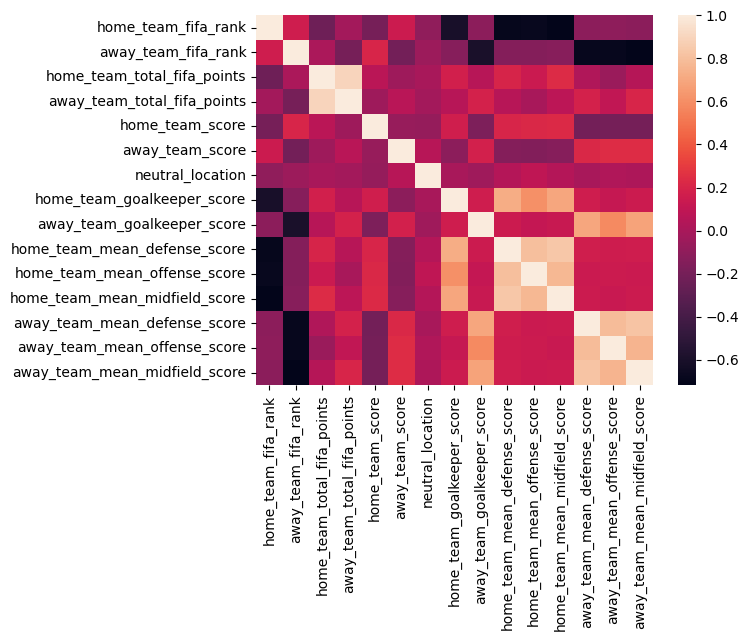

In [7]:
# compute correlations between features
corr = data.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

### _Takeaways_

1. Scores of different positions within the same team and same match are highly positively correlated.
2. Team FIFA rank and positions' scores are highly negatively correlated.

### Plotting features - Histogram

To understand data further, we plot histograms of all numerical features.

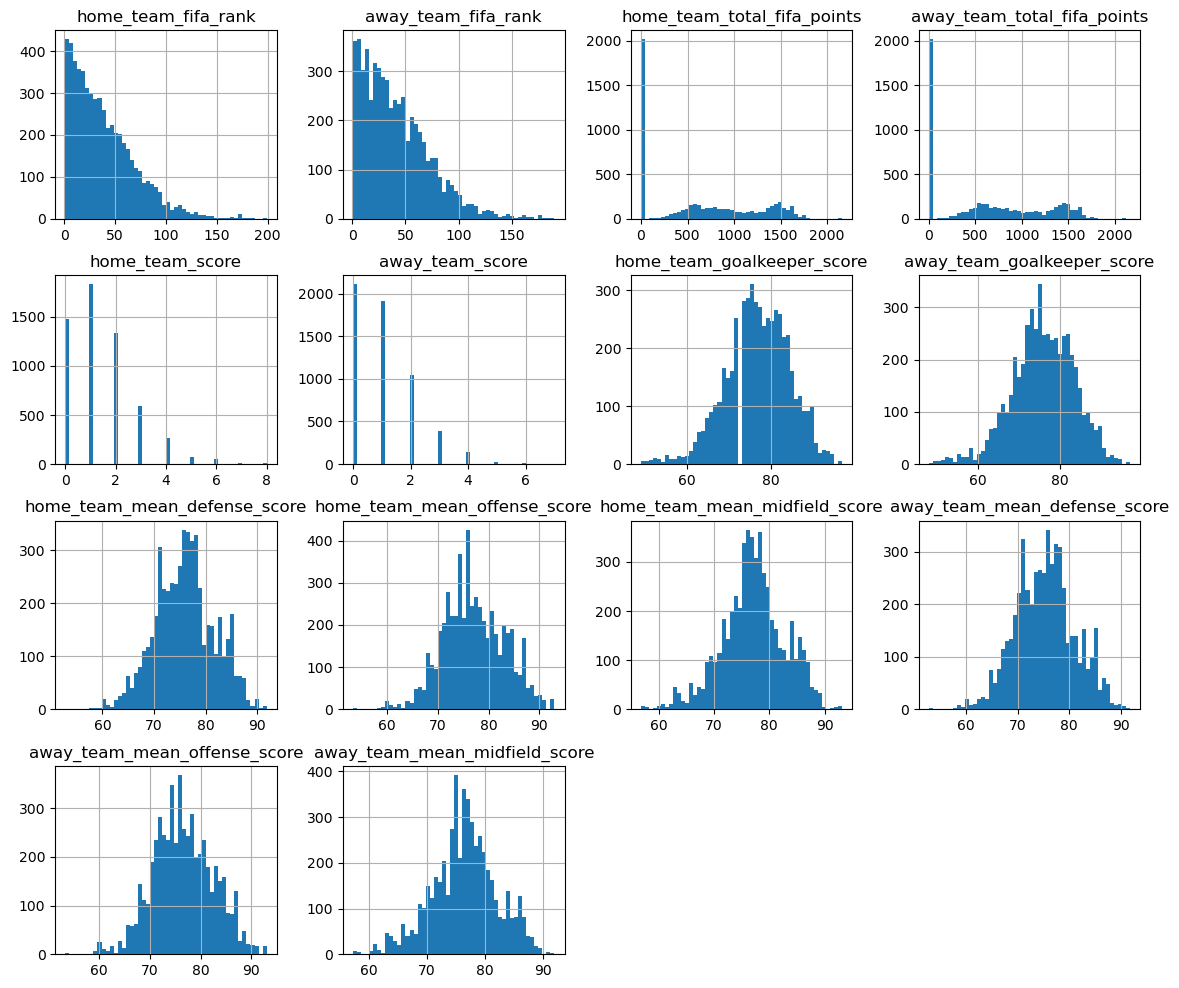

In [9]:
data.hist(bins=50, figsize=(14, 12))
plt.show()

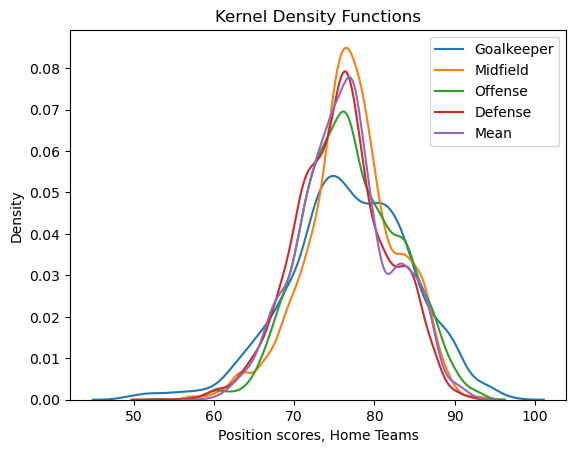

In [10]:
# Plot of Kernel Density Functions for continuos variables in data (i.e., scores), for home_teams
from seaborn import kdeplot
data_kde = data
kdeplot(data=data_kde, x="home_team_goalkeeper_score", label='Goalkeeper')
kdeplot(data=data_kde, x="home_team_mean_midfield_score", label='Midfield')
kdeplot(data=data_kde, x="home_team_mean_offense_score", label='Offense')
kdeplot(data=data_kde, x="home_team_mean_defense_score", label='Defense')

data_kde['mean_home'] = data_kde.loc[:,['home_team_goalkeeper_score',
                                  'home_team_mean_midfield_score',
                                  'home_team_mean_offense_score',
                                  'home_team_mean_defense_score']].mean(axis=1)
kdeplot(data=data_kde, x="mean_home", label='Mean')

plt.title('Kernel Density Functions')
plt.xlabel('Position scores, Home Teams')
plt.legend()
plt.show()

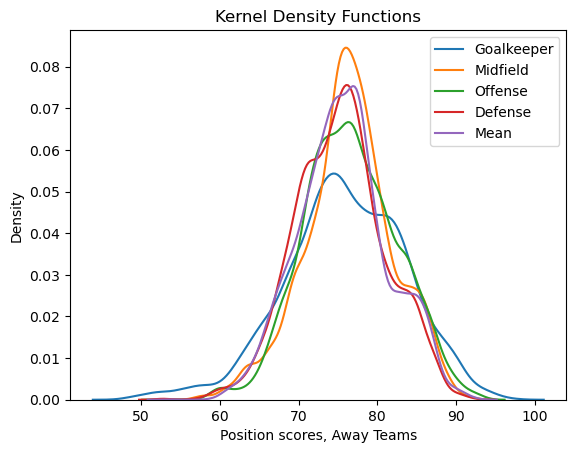

In [11]:
# Plot of Kernel Density Functions for continuos variables in data (i.e., scores), for away_teams
plt.figure()

kdeplot(data=data_kde, x="away_team_goalkeeper_score", label='Goalkeeper')
kdeplot(data=data_kde, x="away_team_mean_midfield_score", label='Midfield')
kdeplot(data=data_kde, x="away_team_mean_offense_score", label='Offense')
kdeplot(data=data_kde, x="away_team_mean_defense_score", label='Defense')

data_kde['mean_away'] = data_kde.loc[:,['away_team_goalkeeper_score',
                                  'away_team_mean_midfield_score',
                                  'away_team_mean_offense_score',
                                  'away_team_mean_defense_score']].mean(axis=1)
kdeplot(data=data_kde, x="mean_away", label='Mean')

plt.title('Kernel Density Functions')
plt.xlabel('Position scores, Away Teams')
plt.legend()
plt.show()

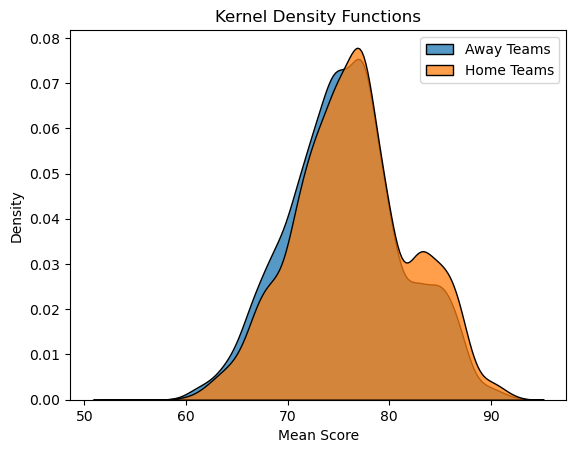

In [12]:
# Combine mean KDE for away and home teams on same plot
plt.figure()
kdeplot(data=data_kde, x="mean_away", label='Away Teams', multiple="stack")
kdeplot(data=data_kde, x="mean_home", label='Home Teams', multiple="stack")

plt.xlabel('Mean Score')
plt.title('Kernel Density Functions')
plt.legend()
plt.show()

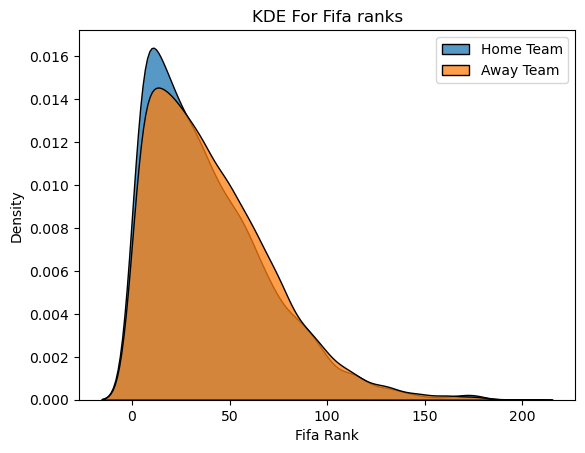

In [13]:
# Distribution plots for other features
# FIFA Ranks
plt.figure()

kdeplot(data=data_kde, x="home_team_fifa_rank", label='Home Team', multiple="stack")
kdeplot(data=data_kde, x="away_team_fifa_rank", label='Away Team', multiple="stack")

plt.xlabel('Fifa Rank')
plt.title('KDE For Fifa ranks')
plt.legend()
plt.show()

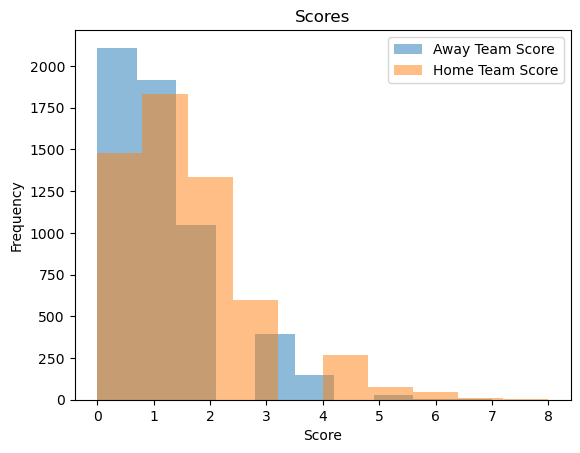

In [14]:
# Goals scored in matches
plt.figure()

plt.hist(x=data['away_team_score'], label='Away Team Score', alpha=0.5)
plt.hist(x=data['home_team_score'], label='Home Team Score', alpha=0.5)

plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Scores')
plt.show()

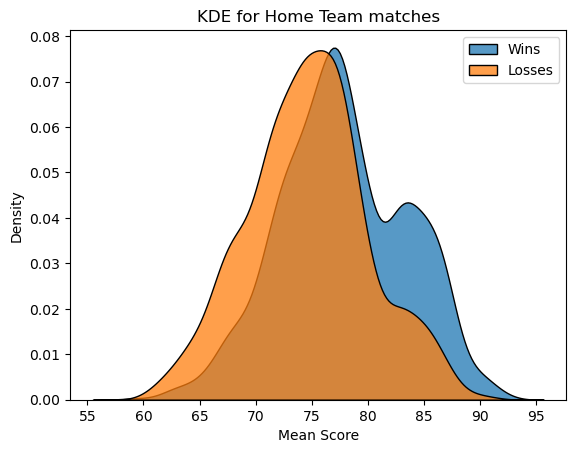

In [15]:
# Splitting Wins and Draws for home_teams
plt.figure()

kdeplot(data=data_kde.loc[data_kde['home_team_result']=='Win'], x="mean_home", label='Wins', multiple="stack")
kdeplot(data=data_kde.loc[data_kde['home_team_result']=='Lose'], x="mean_home", label='Losses', multiple="stack")

plt.xlabel('Mean Score')
plt.title('KDE for Home Team matches')
plt.legend()
plt.show()

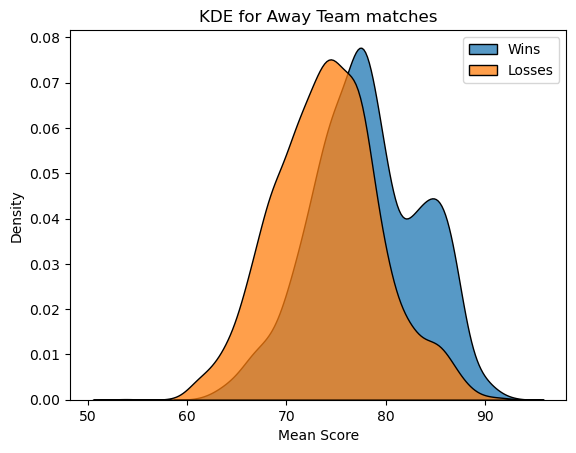

In [17]:
# Splitting Wins and Draws for away_teams
plt.figure()

kdeplot(data=data_kde.loc[data_kde['home_team_result']=='Lose'], x="mean_away", label='Wins', multiple="stack")
kdeplot(data=data_kde.loc[data_kde['home_team_result']=='Win'], x="mean_away", label='Losses', multiple="stack")

plt.xlabel('Mean Score')
plt.title('KDE for Away Team matches')
plt.legend()
plt.show()

### _Takeaways_

1. FIFA points columns (_home_team_total_fifa_points_ and _away_team_total_fifa_points_) have a large number of zeroes, which seems like a problem with the data and needs to be investigated further.
2. _home_team_goalkeeper_score_ seems to have a gap at around 72.
3. Most other data roughly follows normal distributions.

### Probing FIFA points

In order to clean the data, we first need to understand why there are large numbers of zero values in the FIFA points columns.

In [9]:
# select all rows where home team fifa points is zero
zero_points = data.query('home_team_total_fifa_points == 0')
zero_points.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8


In [10]:
# printing them in descending order by date
zero_points.sort_values(by = 'date', ascending=False).head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
2016,2011-08-10,Wales,Australia,Europe,Oceania,112,22,0,0,1,...,No,Lose,75.0,80.0,74.2,71.0,80.2,72.5,76.7,71.0
2001,2011-08-10,Israel,Côte d'Ivoire,Europe,Africa,32,15,0,0,3,...,No,Lose,78.0,72.0,67.0,69.0,73.8,75.8,83.3,77.2
1989,2011-08-10,Austria,Slovakia,Europe,Europe,66,29,0,0,1,...,No,Lose,75.0,72.0,74.0,74.0,74.8,74.8,77.3,74.2
1990,2011-08-10,Belarus,Bulgaria,Europe,Europe,42,48,0,0,1,...,No,Win,75.0,77.0,63.0,71.0,72.2,71.2,75.3,75.0
1991,2011-08-10,Bosnia and Herzegovina,Greece,Europe,Europe,41,13,0,0,0,...,No,Draw,76.0,74.0,72.5,78.3,77.5,75.5,76.3,75.5


Interesting... All zero values seem to be between the dates of 2004-09-03 and 2011-08-10.

We need to make sure that all values between these dates are zero.

In [11]:
# printing all values not equal to zero and lower than the upper boundary (home team)
nonzero_points = data.query('home_team_total_fifa_points != 0')
nonzero_points[nonzero_points['date'] <= dt.date(2011, 8, 10)]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


In [12]:
# printing all values not equal to zero and lower than the upper boundary (away team)
nonzero_points = data.query('away_team_total_fifa_points != 0')
nonzero_points[nonzero_points['date'] <= dt.date(2011, 8, 10)]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


We found something! It seems like the dataset is missing values for the fifa points before 2011-08-10, this will need to be cleaned up

### Data cleansing

Now that we understand the data better, it is time to clean it up before training the model.

### Position scores

From printing the first few values of the data, we also realised there were some null (or NaN) values at in the columns displaying the scores of the different positions (home team defense, away team goalkeeper, etc).

Nonetheless, as seen in the correlations diagram, there is a strong correlation between one position's score and the score of the other positions (within the same match). Therefore, we have chosen to fill in the NaN values with the average of the other positions within the team each match.

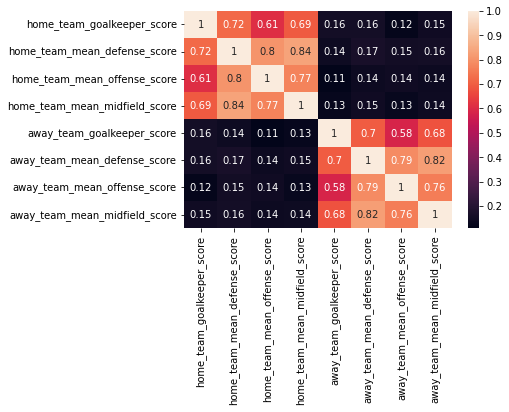

In [13]:
# compute correlations between team points
corr = data[['home_team_goalkeeper_score', \
             'home_team_mean_defense_score', \
             'home_team_mean_offense_score',\
             'home_team_mean_midfield_score', \
             'away_team_goalkeeper_score', \
             'away_team_mean_defense_score', \
             'away_team_mean_offense_score', \
             'away_team_mean_midfield_score']].corr()

heatmap(corr, annot=True)

plt.show()

In [14]:
# remember NaN values are ignored when calculating the average
home_mean = data[['home_team_goalkeeper_score', \
                  'home_team_mean_defense_score', \
                  'home_team_mean_offense_score',\
                  'home_team_mean_midfield_score']].mean(axis=1)

home_mean.head()

0    89.825
1    66.750
2    76.550
3    78.800
4    82.000
dtype: float64

In [15]:
clean_data = data
for i, col in enumerate(clean_data):
    clean_data.iloc[:, i] = data.iloc[:, i].fillna(home_mean)
    
clean_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


In [16]:
# checking if there are any remaining NaN values
data_nan = clean_data[clean_data.isna().any(axis=1)]
data_nan.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


Perfect! As we can see we have been able to replace all NaN values in the position scores section with the averages of the teams' scores.

### FIFA points cleanup

Given the values equal to zero in the FIFA points columns, we want to understand better how to get clean them.

In [17]:
# indentifying the data with FIFA points
mask = clean_data['date'] > dt.date(2011, 8, 10)
data_post2011 = clean_data.loc[mask]

data_post2011.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
2017,2011-08-27,Angola,Congo DR,Africa,Africa,96,127,338,221,1,...,No,Lose,70.0,67.066667,67.066667,69.7,61.5,69.2,69.7,70.0
2018,2011-09-02,Albania,France,Europe,Europe,57,15,546,918,1,...,No,Lose,70.0,86.000000,70.400000,69.7,71.5,82.5,83.0,84.5
2019,2011-09-02,Argentina,Venezuela,South America,South America,9,44,1016,615,1,...,No,Win,77.0,64.000000,80.800000,88.3,85.2,72.2,73.7,75.5
2020,2011-09-02,Belarus,Bosnia and Herzegovina,Europe,Europe,41,39,645,655,0,...,No,Lose,75.0,76.000000,63.200000,67.3,68.0,72.0,77.7,78.0
2021,2011-09-02,Bulgaria,England,Europe,Europe,51,4,585,1176,0,...,No,Lose,80.0,83.000000,70.800000,73.7,73.5,84.0,81.3,85.8


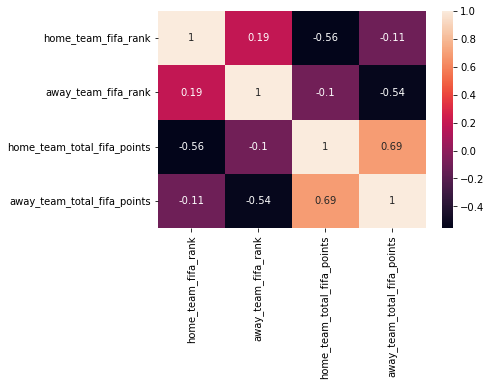

In [18]:
# compute correlations between features
corr = data_post2011[['home_team_fifa_rank', \
                      'away_team_fifa_rank', \
                      'home_team_total_fifa_points', \
                      'away_team_total_fifa_points']].corr()

heatmap(corr, annot=True)

plt.show()

Given the correlation between FIFA rank and FIFA points, we will drop the points feature in favour of rank.

In [19]:
clean_data = clean_data.drop(columns=['home_team_total_fifa_points','away_team_total_fifa_points'])
clean_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_score,away_team_score,tournament,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,1,1,Friendly,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,2,1,FIFA World Cup qualification,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,2,2,FIFA World Cup qualification,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,3,0,FIFA World Cup qualification,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,1,1,FIFA World Cup qualification,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


### Other cleanup

In order to feed the model the right data, we clean up further by dropping the date, continents, tournament, city, country and neutral location.

In [20]:
# Continents
clean_data['home_team_continent'].unique()

array(['Europe', 'Africa', 'South America', 'North America', 'Oceania',
       'Asia'], dtype=object)

In [21]:
# encoding string features as integers
le = LabelEncoder()

clean_data['home_team_continent'] = le.fit_transform(clean_data['home_team_continent'])
clean_data['away_team_continent'] = le.fit_transform(clean_data['away_team_continent'])
clean_data['city'] = le.fit_transform(clean_data['city'])
clean_data['country'] = le.fit_transform(clean_data['country'])

In [22]:
# Tournament
clean_data['tournament'].unique()

array(['Friendly', 'FIFA World Cup qualification', "King's Cup",
       'CFU Caribbean Cup', 'Confederations Cup', 'Gold Cup',
       'EAFF Championship', 'African Cup of Nations',
       'Lunar New Year Cup', 'Cyprus International Tournament',
       'Kirin Cup', 'FIFA World Cup', 'UEFA Euro qualification',
       'African Cup of Nations qualification', 'Copa del Pacífico',
       'Copa América', 'AFC Asian Cup', 'UEFA Euro', 'COSAFA Cup',
       'Baltic Cup', 'UNCAF Cup', 'Nations Cup', 'Copa Confraternidad',
       'Superclásico de las Américas', 'Nehru Cup',
       'African Nations Championship', 'Kirin Challenge Cup', 'OSN Cup',
       'CFU Caribbean Cup qualification', 'Intercontinental Cup',
       'UEFA Nations League',
       'African Nations Championship qualification',
       'CONCACAF Nations League', 'Arab Cup'], dtype=object)

In [23]:
clean_data['tournament'] = (clean_data['tournament'] == 'Friendly').astype(int) # 1 Friendly 0 Else

In [24]:
# Neutral location
clean_data['neutral_location'].unique()

array([False,  True])

In [25]:
clean_data['neutral_location'] = clean_data['neutral_location'].map({True:1, False:0})

In [26]:
# Shoot out
clean_data['shoot_out'].unique()

array(['No', 'Yes'], dtype=object)

In [27]:
# if shoot out then equivalent to Draw in world cup group stage
clean_data['home_team_result'] = np.where(clean_data['shoot_out']=='Yes', 'Draw', clean_data['home_team_result'])
clean_data = clean_data.drop(columns=['shoot_out'])

In [28]:
# Home team result
clean_data['home_team_result'].unique()

array(['Draw', 'Win', 'Lose'], dtype=object)

In [29]:
clean_data['home_team_result'] = clean_data['home_team_result'].map({'Win':1, 'Draw':0, 'Lose':-1})

In [30]:
clean_data = clean_data.drop(columns=['home_team_score','away_team_score'])

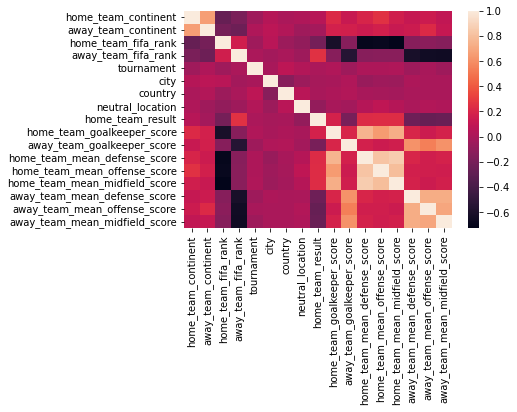

In [31]:
corr = clean_data.corr()

heatmap(corr)

plt.show()

Investigating further...

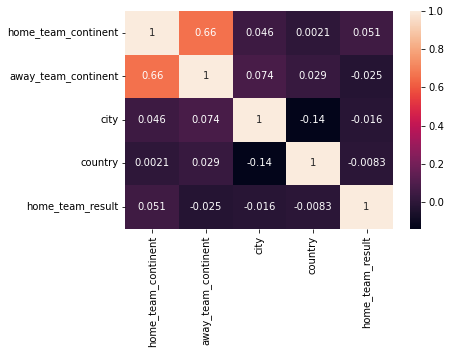

In [32]:
corr = clean_data[['home_team_continent', \
                   'away_team_continent', \
                   'city', \
                   'country', \
                   'home_team_result']].corr()

heatmap(corr, annot=True)

plt.show()

Which implies that there is little relation between the features and the result, therefore we drop them.

In [33]:
clean_data = clean_data.drop(columns=['home_team_continent', 'away_team_continent', 'city', 'country'])

In [34]:
# copy final clean data with date for later use, remove for algorithms
date_data = clean_data
clean_data_hold = clean_data # used for feature engineering
clean_data = clean_data.drop(columns=['date'])

In [35]:
# encode home and away teams as ints
le.fit(clean_data['away_team'])

clean_data['home_team'] = le.transform(clean_data['home_team'])
clean_data['away_team'] = le.transform(clean_data['away_team'])

clean_data.head()

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,96,89,3,67,1,0,0,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,0,45,94,14,0,0,1,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,6,36,90,7,0,0,0,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,28,50,25,76,0,0,1,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,33,106,15,87,0,0,0,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


In [36]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team                      5641 non-null   int64  
 1   away_team                      5641 non-null   int64  
 2   home_team_fifa_rank            5641 non-null   int64  
 3   away_team_fifa_rank            5641 non-null   int64  
 4   tournament                     5641 non-null   int64  
 5   neutral_location               5641 non-null   int64  
 6   home_team_result               5641 non-null   int64  
 7   home_team_goalkeeper_score     5641 non-null   float64
 8   away_team_goalkeeper_score     5641 non-null   float64
 9   home_team_mean_defense_score   5641 non-null   float64
 10  home_team_mean_offense_score   5641 non-null   float64
 11  home_team_mean_midfield_score  5641 non-null   float64
 12  away_team_mean_defense_score   5641 non-null   f

## Feature engineering

Now that the training data is clean, we want to adapt the test and prediction data so that the performance of the model can be assessed.

The main issue is that the datasets for testing (`test_set.csv`) and predicting (`woldcup_2022.csv`) do not have all the required features. Therefore, we need to engineer them in a way that is accurate enough for the model to have good results.

In [37]:
pd.options.mode.chained_assignment = None  # default='warn', avoids annoing warnings

### Argentina exploration
We explore the evolution of position scores in Argentina's team to then extrapolate for feature engineering.

In [38]:
pd.options.mode.chained_assignment = None  # default='warn', avoids annoying warnings

In [39]:
# Create a var containing rows regarding Argentina only
team = 'Argentina'

argentina_data = clean_data_hold.loc[((clean_data_hold['home_team'] == team) | \
                                      (clean_data_hold['away_team'] == team))]

argentina_data.tail()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
5516,2021-10-07,Paraguay,Argentina,35,6,0,0,0,72.0,84.0,74.2,74.3,76.2,82.2,89.0,84.0
5543,2021-10-10,Argentina,Uruguay,6,12,0,0,1,84.0,80.0,82.2,89.0,84.0,81.2,84.3,80.0
5570,2021-10-14,Argentina,Peru,6,21,0,0,1,84.0,74.0,82.2,89.0,84.0,74.5,73.0,76.8
5597,2021-11-12,Uruguay,Argentina,15,6,0,0,-1,80.0,84.0,81.2,84.3,80.0,82.2,89.0,84.0
5632,2021-11-16,Argentina,Brazil,6,2,0,0,0,84.0,89.0,82.2,89.0,84.0,84.8,86.3,85.5


In [40]:
# Add column for categorising if Argentina is accounted as home or away team
argentina_data['is_home'] = argentina_data['home_team'].map({team:1}, na_action='ignore')
argentina_data['is_home'] = argentina_data['is_home'].replace(np.nan, 0)

In [41]:
# Dropping unused columns
def drop_unused_features(data, team):
    
    if team == 'home':
        columns = ['home_team',
                   'away_team',
                   'away_team_fifa_rank',
                   'tournament',
                   'neutral_location',
                   'away_team_goalkeeper_score',
                   'away_team_mean_defense_score',
                   'away_team_mean_offense_score',
                   'away_team_mean_midfield_score',
                   'is_home'
                  ]
    elif team == 'away':
        columns = ['home_team',
                   'away_team',
                   'home_team_fifa_rank',
                   'tournament',
                   'neutral_location',
                   'home_team_goalkeeper_score',
                   'home_team_mean_defense_score',
                   'home_team_mean_offense_score',
                   'home_team_mean_midfield_score',
                   'is_home'
                  ]

    data = data.drop(columns=columns)
    return data

# Rename columns for merge (home team)
def rename_features_merge(data, team):
    
    if team == 'home':
        columns = {'home_team_fifa_rank':'fifa_rank',
                   'home_team_result':'result',
                   'home_team_goalkeeper_score':'goalkeeper_score',
                   'home_team_mean_defense_score':'mean_defense_score',
                   'home_team_mean_offense_score':'mean_offense_score',
                   'home_team_mean_midfield_score':'mean_midfield_score'
                  }
    elif team == 'away':    
        columns = {'away_team_fifa_rank':'fifa_rank',
                   'home_team_result':'result',
                   'away_team_goalkeeper_score':'goalkeeper_score',
                   'away_team_mean_defense_score':'mean_defense_score',
                   'away_team_mean_offense_score':'mean_offense_score',
                   'away_team_mean_midfield_score':'mean_midfield_score'
                  }
    
    data = data.rename(columns=columns)
    return data

In [42]:
# Build 2 separate DFs for argentina as home and away team
# Drop unused features and rename features with same names  

argentina_scores_home = argentina_data.loc[argentina_data['is_home'] == 1]

# Difference in scores between Argentina and team they played against (absolute values)
argentina_scores_home['rank_team_diff']       = argentina_scores_home['home_team_fifa_rank'].sub(argentina_scores_home['away_team_fifa_rank'], axis=0)
argentina_scores_home['goalkeeper_team_diff'] = argentina_scores_home['home_team_goalkeeper_score'].sub(argentina_scores_home['away_team_goalkeeper_score'], axis=0)
argentina_scores_home['defense_team_diff']    = argentina_scores_home['home_team_mean_defense_score'].sub(argentina_scores_home['away_team_mean_defense_score'], axis=0)
argentina_scores_home['offense_team_diff']    = argentina_scores_home['home_team_mean_offense_score'].sub(argentina_scores_home['away_team_mean_offense_score'], axis=0)
argentina_scores_home['midfield_team_diff']   = argentina_scores_home['home_team_mean_midfield_score'].sub(argentina_scores_home['away_team_mean_midfield_score'], axis=0)
argentina_scores_home['mean_team_diff']       = argentina_scores_home[['goalkeeper_team_diff', 'defense_team_diff', 'offense_team_diff', 'midfield_team_diff']].mean(axis=1)

argentina_scores_home = drop_unused_features(argentina_scores_home, 'home')
argentina_scores_home = rename_features_merge(argentina_scores_home, 'home')

# Same but for away team
argentina_scores_away = argentina_data.loc[argentina_data['is_home'] == 0]

# Difference in scores between Argentina and team they played against (absolute values)
argentina_scores_away['rank_team_diff']       = argentina_scores_away['away_team_fifa_rank'].sub(argentina_scores_away['home_team_fifa_rank'], axis=0)
argentina_scores_away['goalkeeper_team_diff'] = argentina_scores_away['away_team_goalkeeper_score'].sub(argentina_scores_away['home_team_goalkeeper_score'], axis=0)
argentina_scores_away['defense_team_diff']    = argentina_scores_away['away_team_mean_defense_score'].sub(argentina_scores_away['home_team_mean_defense_score'], axis=0)
argentina_scores_away['offense_team_diff']    = argentina_scores_away['away_team_mean_offense_score'].sub(argentina_scores_away['home_team_mean_offense_score'], axis=0)
argentina_scores_away['midfield_team_diff']   = argentina_scores_away['away_team_mean_midfield_score'].sub(argentina_scores_away['home_team_mean_midfield_score'], axis=0)
argentina_scores_away['mean_team_diff']       = argentina_scores_away[['goalkeeper_team_diff', 'defense_team_diff', 'offense_team_diff', 'midfield_team_diff']].mean(axis=1)

argentina_scores_away = drop_unused_features(argentina_scores_away, 'away')
argentina_scores_away = rename_features_merge(argentina_scores_away, 'away')

# change scores for away DF to the same structure as home DF
argentina_scores_away['result'] = argentina_scores_away['result'].map({0:0, 1:-1, -1:1})    

In [43]:
argentina_scores = pd.concat([argentina_scores_home, argentina_scores_away]).sort_index() # Merge 2 DFs
argentina_scores.reset_index(inplace=True, drop=True)
argentina_scores.head()

,date,fifa_rank,result,goalkeeper_score,mean_defense_score,mean_offense_score,mean_midfield_score,rank_team_diff,goalkeeper_team_diff,defense_team_diff,offense_team_diff,midfield_team_diff,mean_team_diff
0,2004-09-04,4,1,78.0,87.0,87.0,88.5,-59,25.0,23.650000,13.3,25.15,21.775000
1,2004-10-09,3,1,78.0,87.0,87.0,88.5,-14,4.0,11.500000,4.0,9.70,7.300000
2,2004-10-13,3,0,78.0,87.0,87.0,88.5,-76,-3.0,9.066667,7.7,15.00,7.191667
3,2005-02-09,3,0,78.0,87.0,87.0,88.5,-13,-16.0,-0.500000,4.3,1.00,-2.800000
4,2005-03-09,3,0,78.0,87.0,87.0,88.5,-3,0.0,11.000000,15.3,12.30,9.650000


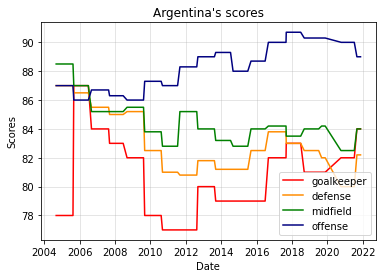

In [44]:
plt.figure()

plt.plot(argentina_scores['date'], 
         argentina_scores['goalkeeper_score'], 
         #color='tomato',
         color='red',
         label='goalkeeper')

plt.plot(argentina_scores['date'], 
         argentina_scores['mean_defense_score'], 
         #color='royalblue',
         color='darkorange',
         label='defense')

plt.plot(argentina_scores['date'], 
         argentina_scores['mean_midfield_score'], 
         #color='forestgreen',
         color='green',
         label='midfield')

plt.plot(argentina_scores['date'], 
         argentina_scores['mean_offense_score'], 
         #color='slategrey',
         color='navy',
         label='offense')

plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's scores")
plt.legend(loc='lower right')
plt.grid(alpha=.4)

plt.show()

We can see that there is a slight correlation between the goalkeeper and defense data, but this is not too strong and there is little correlation with midfield and offense.

Therefore, we continue investigating by looking at the change in scores between matches.

<Figure size 432x288 with 0 Axes>

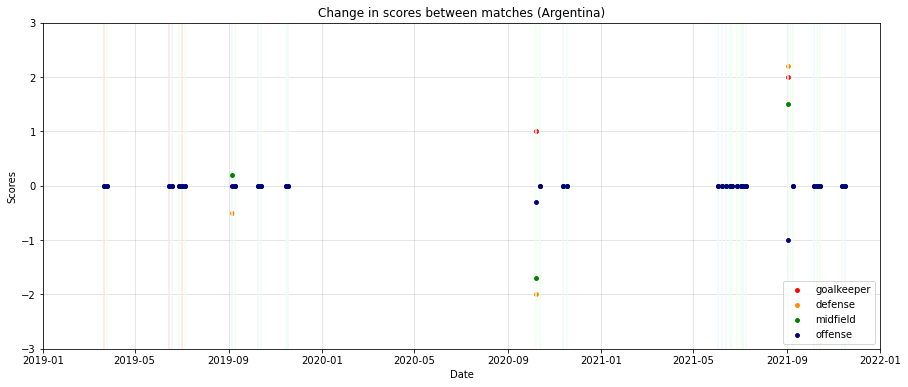

In [45]:
# Compute change in scores between matches
argentina_scores['rank_diff'] = argentina_scores['fifa_rank'].diff()
argentina_scores['goalkeeper_diff'] = argentina_scores['goalkeeper_score'].diff()
argentina_scores['defense_diff'] = argentina_scores['mean_defense_score'].diff()
argentina_scores['midfield_diff'] = argentina_scores['mean_midfield_score'].diff()
argentina_scores['offense_diff'] = argentina_scores['mean_offense_score'].diff()

plt.figure()
plt.figure(figsize=(15, 6))

for i in argentina_scores['date'].loc[argentina_scores['result']==1]:
    ax = plt.axvline(
        x=i,
        color='honeydew'
    )
for i in argentina_scores['date'].loc[argentina_scores['result']==0]:
    plt.axvline(
        x=i,
        color='aliceblue'
    )
for i in argentina_scores['date'].loc[argentina_scores['result']==-1]:
    plt.axvline(
        x=i,
        color='mistyrose'
    )


plt.scatter(argentina_scores['date'], 
            argentina_scores['goalkeeper_diff'], 
            color='red',
            label='goalkeeper',
            s=15,
            zorder=1
)
plt.scatter(argentina_scores['date'], 
            argentina_scores['defense_diff'], 
            color='darkorange',
            label='defense',
            s=15,
            zorder=2
)
plt.scatter(argentina_scores['date'], 
            argentina_scores['midfield_diff'], 
            color='green',
            label='midfield',
            s=15,
            zorder=3
)
plt.scatter(argentina_scores['date'], 
            argentina_scores['offense_diff'], 
            color='navy',
            label='offense',
            s=15,
            zorder=4
)

plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Change in scores between matches (Argentina)")
plt.legend(loc='lower right')
plt.grid(alpha=.4)

plt.xlim([dt.date(2019, 1, 1), dt.date(2022, 1, 1)])
plt.ylim(-3, 3)

plt.show()

Again, it is difficult to draw any conclusions from the data above to extrapolate scores for feature engineering.

Therefore, we keep investigating, looking at whether the changes are related to performance against stronger or weaker teams.

In [46]:
# Finding when wins over stronger teams or draws/losses against weaker teams took place

# Losing/drawing against weaker team
argentina_scores_deviation_negative = argentina_scores.loc[((argentina_scores['result'] == 0|-1) & (argentina_scores['mean_team_diff']>0))]
# Wining/drawing against stronger team
argentina_scores_deviation_positive = argentina_scores.loc[((argentina_scores['result'] == 1|0) & (argentina_scores['mean_team_diff']<0))]

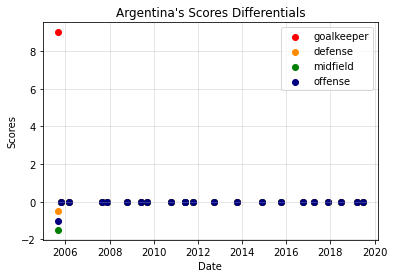

In [47]:
# Compute change in scores between matches where Argentina loses/draws against weaker team
plt.figure()

plt.scatter(argentina_scores_deviation_negative['date'], 
            argentina_scores_deviation_negative['goalkeeper_diff'], 
            color='red',
            label='goalkeeper'
)
plt.scatter(argentina_scores_deviation_negative['date'], 
            argentina_scores_deviation_negative['defense_diff'], 
            color='darkorange',
            label='defense'
)
plt.scatter(argentina_scores_deviation_negative['date'], 
            argentina_scores_deviation_negative['midfield_diff'], 
            color='green',
            label='midfield'
)
plt.scatter(argentina_scores_deviation_negative['date'], 
            argentina_scores_deviation_negative['offense_diff'], 
            color='navy',
            label='offense'
)

plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's Scores Differentials")
plt.legend(loc='upper right')
plt.grid(alpha=.4)

plt.show()

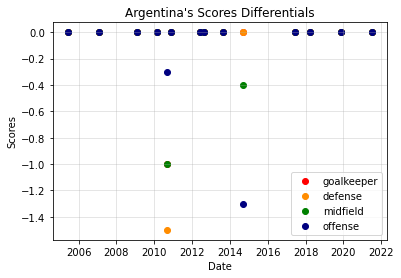

In [48]:
# Compute change in scores between matches where Argentina wins/draws against stronger team
plt.figure()

plt.scatter(argentina_scores_deviation_positive['date'], 
            argentina_scores_deviation_positive['goalkeeper_diff'], 
            color='red',
            label='goalkeeper'
)
plt.scatter(argentina_scores_deviation_positive['date'], 
            argentina_scores_deviation_positive['defense_diff'], 
            color='darkorange',
            label='defense'
)
plt.scatter(argentina_scores_deviation_positive['date'], 
            argentina_scores_deviation_positive['midfield_diff'], 
            color='green',
            label='midfield'
)
plt.scatter(argentina_scores_deviation_positive['date'], 
            argentina_scores_deviation_positive['offense_diff'], 
            color='navy',
            label='offense'
)

plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's Scores Differentials")
plt.legend(loc='lower right')
plt.grid(alpha=.4)

plt.show()

### _Takeaways_

1. Not all the spikes are highlighted. 
2. Where I was expecting mainly positive variations I got negatives. So this is not the way.

Since no specific trend is found and big surges/drops in the scores are identified, it is sensible to fit to the following 6 months for engineering the test set the line of best fit, intended as the derivative. Since matches that are not recent are less relevant to the team performance in 2022, the derivative has been computed only over the last 2.5 years

### Feature engineering setup

In [49]:
ref_date = dt.date(2019, 1, 1)
#argentina_scores.drop(argentina_scores[argentina_scores['date']<ref_date].index, inplace=True)

In [50]:
derivative = pd.DataFrame()
date_diff = pd.DataFrame()

feature_list = ['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_scor3e']

#score_diff = []
#date_diff['date'] = argentina_scores['date'].diff(periods=(len(argentina_scores)-1)).reset_index(drop=True)
#date_diff_num = date_diff.at[(len(argentina_scores)-1),'date']

#for i in feature_list:
#    derivative[i] = argentina_scores[i].diff(periods=(len(argentina_scores)-1)).reset_index(drop=True)
#    j = derivative.at[(len(argentina_scores)-1),i]
#    score_diff.append(j)

In [51]:
def team_score_derivative(team, ref_date):
    
    # Fetch all rows containing specific team
    team_data = clean_data_hold.loc[((clean_data_hold['home_team'] == team) | (clean_data_hold['away_team'] == team))]
    
    team_data.loc[:,('is_home')] = team_data.loc[:,('home_team')].map({team:1}, na_action='ignore')
    team_data.loc[:,('is_home')] = team_data.loc[:,('is_home')].replace(np.nan, 0)
    
    # Build 2 separate DFs for argentina as home and away team
    team_scores_home = team_data.loc[team_data['is_home'] == 1]

    team_scores_home = drop_unused_features(team_scores_home, 'home')
    team_scores_home = rename_features_merge(team_scores_home, 'home')
    
    team_scores_away = team_data.loc[team_data['is_home'] == 0]

    team_scores_away = drop_unused_features(team_scores_away, 'away')
    team_scores_away = rename_features_merge(team_scores_away, 'away')

    # Change scores for away DF to the same structure as home DF
    team_scores_away['result'] = team_scores_away['result'].map({0:0, 1:-1, -1:1})
    
    # Merge DFs
    team_scores = pd.concat([team_scores_home, team_scores_away]).sort_index() # Merge 2 DFs
    team_scores.reset_index(inplace=True, drop=True)
    
    # Drop matches before reference date
    team_scores.drop(team_scores[team_scores['date']<ref_date].index, inplace=True)
    
    # Allocate variables for deriivatives computation
    derivative = pd.DataFrame()
    date_diff = pd.DataFrame()

    feature_list = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])

    score_diff = np.array([])
    date_diff['date'] = team_scores['date'].diff(periods=(len(team_scores)-1)).reset_index(drop=True)
    if len(team_scores) != 0:
        date_diff_num = ([date_diff.at[(len(team_scores)-1),'date']])
    else: date_diff_num = None

    for i in feature_list:
        derivative[i] = team_scores[i].diff(periods=(len(team_scores)-1)).reset_index(drop=True)
        j = derivative.at[(len(team_scores)-1),i].round(2)
        score_diff = np.append(score_diff, j)

    return (score_diff, date_diff_num)
        

## Test data

In [52]:
ref_date = dt.date(2019, 1, 1)

score_diff_all_teams = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])
date_diff_all_teams = np.array(['date'])

In [53]:
# Drop columns for scores, as we need to engineer them and using them is not admitted
international_matches = international_matches[['date','home_team','away_team','shoot_out','neutral_location','home_team_result','tournament']]
international_matches.head()

,date,home_team,away_team,shoot_out,neutral_location,home_team_result,tournament
23350,2022-01-02,Gabon,Burkina Faso,No,True,Lose,Friendly
23351,2022-01-02,Sudan,Zimbabwe,No,True,Draw,Friendly
23352,2022-01-03,Rwanda,Guinea,No,False,Win,Friendly
23353,2022-01-04,Mauritania,Gabon,No,True,Draw,Friendly
23354,2022-01-05,Algeria,Ghana,No,True,Win,Friendly


In [54]:
# Merge 2 DFs according to test_data columns
test_data = test_data.merge(international_matches, how='inner', on=['date','home_team','away_team','home_team_result'])
test_data.head()

,date,home_team,away_team,home_team_result,shoot_out,neutral_location,tournament
0,2022-01-02,Gabon,Burkina Faso,Lose,No,True,Friendly
1,2022-01-05,Algeria,Ghana,Win,No,True,Friendly
2,2022-01-09,Cameroon,Burkina Faso,Win,No,False,African Cup of Nations
3,2022-01-10,Senegal,Zimbabwe,Win,No,True,African Cup of Nations
4,2022-01-10,Morocco,Ghana,Win,No,True,African Cup of Nations


In [55]:
countries_test = np.unique(test_data[['home_team', 'away_team']].values)
countries_test

array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Belgium', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso',
       'Cabo Verde', 'Cameroon', 'Canada', 'Chile', 'China PR',
       'Colombia', 'Congo', 'Congo DR', 'Costa Rica', 'Croatia',
       'Curaçao', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'Denmark',
       'Ecuador', 'Egypt', 'England', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guinea',
       'Guinea-Bissau', 'Honduras', 'Hungary', 'IR Iran', 'Iceland',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Korea Republic', 'Kosovo',
       'Luxembourg', 'Madagascar', 'Mali', 'Mexico', 'Montenegro',
       'Morocco', 'Netherlands', 'New Zealand', 'Nigeria',
       'North Macedonia', 'Northern Ireland', 'Norway', 'Panama',
       'Paraguay', 'Peru', 'Poland', 'Portugal', 'Republic of Ireland',
       'Romania', 'Saudi Arabia', 'Scotland', 'Senegal', '

In [56]:
# initialise remaining features
test_data = test_data.assign(home_team_fifa_rank=np.zeros(len(test_data), dtype=int))
test_data = test_data.assign(away_team_fifa_rank=np.zeros(len(test_data), dtype=int))
test_data = test_data.assign(home_team_goalkeeper_score=np.zeros(len(test_data), dtype=float))
test_data = test_data.assign(away_team_goalkeeper_score=np.zeros(len(test_data), dtype=float))
test_data = test_data.assign(home_team_mean_defense_score=np.zeros(len(test_data), dtype=float))
test_data = test_data.assign(home_team_mean_offense_score=np.zeros(len(test_data), dtype=float))
test_data = test_data.assign(home_team_mean_midfield_score=np.zeros(len(test_data), dtype=float))
test_data = test_data.assign(away_team_mean_defense_score=np.zeros(len(test_data), dtype=float))
test_data = test_data.assign(away_team_mean_offense_score=np.zeros(len(test_data), dtype=float))
test_data = test_data.assign(away_team_mean_midfield_score=np.zeros(len(test_data), dtype=float))

In [57]:
# function to update missing prediction data with last match outcomes
def update_data(country, data):
    last_home = date_data.query("home_team == @country").tail(1)
    last_away = date_data.query("away_team == @country").tail(1)   
    
    if last_home['date'].item() > last_away['date'].item():

        data['home_team_fifa_rank'] = np.where(data['home_team'] == country, \
                                                    last_home['home_team_fifa_rank'].item(), \
                                                    data['home_team_fifa_rank'])
        data['home_team_goalkeeper_score'] = np.where(data['home_team'] == country, \
                                                           last_home['home_team_goalkeeper_score'].item(), \
                                                           data['home_team_goalkeeper_score'])
        data['home_team_mean_defense_score'] = np.where(data['home_team'] == country, \
                                                             last_home['home_team_mean_defense_score'].item(), \
                                                             data['home_team_mean_defense_score'])
        data['home_team_mean_offense_score'] = np.where(data['home_team'] == country, \
                                                             last_home['home_team_mean_offense_score'].item(), \
                                                             data['home_team_mean_offense_score'])
        data['home_team_mean_midfield_score'] = np.where(data['home_team'] == country, \
                                                              last_home['home_team_mean_midfield_score'].item(), \
                                                              data['home_team_mean_midfield_score'])

        data['away_team_fifa_rank'] = np.where(data['away_team'] == country, \
                                                    last_home['home_team_fifa_rank'].item(), \
                                                    data['away_team_fifa_rank'])
        data['away_team_goalkeeper_score'] = np.where(data['away_team'] == country, \
                                                           last_home['home_team_goalkeeper_score'].item(), \
                                                           data['away_team_goalkeeper_score'])
        data['away_team_mean_defense_score'] = np.where(data['away_team'] == country, \
                                                             last_home['home_team_mean_defense_score'].item(), \
                                                             data['away_team_mean_defense_score'])
        data['away_team_mean_offense_score'] = np.where(data['away_team'] == country, \
                                                             last_home['home_team_mean_offense_score'].item(), \
                                                             data['away_team_mean_offense_score'])
        data['away_team_mean_midfield_score'] = np.where(data['away_team'] == country, \
                                                              last_home['home_team_mean_midfield_score'].item(), \
                                                              data['away_team_mean_midfield_score'])
        
    else:
        data['home_team_fifa_rank'] = np.where(data['home_team'] == country, \
                                                    last_away['away_team_fifa_rank'].item(), \
                                                    data['home_team_fifa_rank'])
        data['home_team_goalkeeper_score'] = np.where(data['home_team'] == country, \
                                                           last_away['away_team_goalkeeper_score'].item(), \
                                                           data['home_team_goalkeeper_score'])
        data['home_team_mean_defense_score'] = np.where(data['home_team'] == country, \
                                                             last_away['away_team_mean_defense_score'].item(), \
                                                             data['home_team_mean_defense_score'])
        data['home_team_mean_offense_score'] = np.where(data['home_team'] == country, \
                                                             last_away['away_team_mean_offense_score'].item(), \
                                                             data['home_team_mean_offense_score'])
        data['home_team_mean_midfield_score'] = np.where(data['home_team'] == country, \
                                                              last_away['away_team_mean_midfield_score'].item(), \
                                                              data['home_team_mean_midfield_score'])

        data['away_team_fifa_rank'] = np.where(data['away_team'] == country, \
                                                    last_away['away_team_fifa_rank'].item(), \
                                                    data['away_team_fifa_rank'])
        data['away_team_goalkeeper_score'] = np.where(data['away_team'] == country, \
                                                           last_away['away_team_goalkeeper_score'].item(), \
                                                           data['away_team_goalkeeper_score'])
        data['away_team_mean_defense_score'] = np.where(data['away_team'] == country, \
                                                             last_away['away_team_mean_defense_score'].item(), \
                                                             data['away_team_mean_defense_score'])
        data['away_team_mean_offense_score'] = np.where(data['away_team'] == country, \
                                                             last_away['away_team_mean_offense_score'].item(), \
                                                             data['away_team_mean_offense_score'])
        data['away_team_mean_midfield_score'] = np.where(data['away_team'] == country, \
                                                              last_away['away_team_mean_midfield_score'].item(), \
                                                              data['away_team_mean_midfield_score'])
    return data

In [58]:
# Execute above function for all countries. DO NOT RUN TWICE
for i in countries_test:
    if i != 'Suriname':
        test_data = update_data(i, test_data)

In [59]:
# Calculate differentials for countries in test_data
ref_date = dt.date(2019, 1, 1)

score_diff_all_teams = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])
date_diff_all_teams = np.array(['date'])

pd.options.mode.chained_assignment = None  # default='warn', avoids annoing warnings

for i in countries_test:
    
    if i != 'Suriname':
               
        score_diff_s, date_diff_num_s = team_score_derivative(i, ref_date)

        score_diff_all_teams = np.vstack([score_diff_all_teams,  score_diff_s])
        date_diff_all_teams  = np.vstack([date_diff_all_teams, date_diff_num_s]) 

        
score_diff_all_teams_df = pd.DataFrame(score_diff_all_teams, columns=['fifa_rank',
                                                                      'goalkeeper_score',
                                                                      'mean_defense_score',
                                                                      'mean_offense_score',
                                                                      'mean_midfield_score']).round(2).iloc[1: , :].astype(float)

date_diff_all_teams_df = pd.DataFrame(date_diff_all_teams, columns=['deltas'])
date_diff_all_teams_df = date_diff_all_teams_df.iloc[1: , :]

date_diff_all_teams_df['days'] = (date_diff_all_teams_df['deltas'] / np.timedelta64(1, 'D')).astype(int)
date_diff_all_teams_df = date_diff_all_teams_df.drop(columns=['deltas'])

To calculate the deltas, the dates of the first match for every team i `test_data` needs to be saved in an array.

In [60]:
first_date = np.array([])
for i in countries_test:
    team_set = test_data.loc[((test_data['home_team'] == i) | (test_data['away_team'] == i))]
    team_date = team_set['date'].head(1)
    first_date = np.append(first_date, team_date)

Now we need to add the derivative to all the scores filled in the `test_data`.

In [61]:
def update_scores_derivatives(country, j, data):

    #j: Counts teams, i.e. rows in score_diff_all_teams
    
    dates_home = pd.DataFrame([])
    dates_home['date'] = data['date'].loc[(data['home_team']==country)].reset_index(drop=True)
    dates_home['deltas'] = dates_home['date'].diff()
    dates_home = dates_home.iloc[1: , :]
    dates_home['days'] = (dates_home['deltas'] / np.timedelta64(1, 'D')).astype(int)
    dates_home = dates_home.drop(columns=['deltas','date'])
    
    if len(dates_home!=0):

        home_team_index = data.index[data['home_team']==country].tolist()
        
        date_diff_this_team = int(date_diff_all_teams_df.loc[j,'days'])

        for k in [home_team_index]:
            a = 1 # Counts progress in dates_home
            dates_home_s = int(dates_home.loc[a,'days'])

            data.loc[k,'home_team_fifa_rank']           = (data.loc[k,'home_team_fifa_rank'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,0])*(dates_home_s/date_diff_this_team))
            data.loc[k,'home_team_goalkeeper_score']    = (data.loc[k,'home_team_goalkeeper_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,1])*(dates_home_s/date_diff_this_team))
            data.loc[k,'home_team_mean_defense_score']  = (data.loc[k,'home_team_mean_defense_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,2])*(dates_home_s/date_diff_this_team))
            data.loc[k,'home_team_mean_offense_score']  = (data.loc[k,'home_team_mean_offense_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,3])*(dates_home_s/date_diff_this_team))
            data.loc[k,'home_team_mean_midfield_score'] = (data.loc[k,'home_team_mean_midfield_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,4])*(dates_home_s/date_diff_this_team))
            a += 1
        else : None
    
    
    dates_away = pd.DataFrame([])
    dates_away['date'] = data['date'].loc[(data['away_team']==country)].reset_index(drop=True)
    dates_away['deltas'] = dates_away['date'].diff()
    dates_away = dates_away.iloc[1: , :]
    dates_away['days'] = (dates_away['deltas'] / np.timedelta64(1, 'D')).astype(int)
    dates_away = dates_away.drop(columns=['deltas','date'])
   
    if len(dates_away!=0):
        
        away_team_index = data.index[data['away_team']==country].tolist().pop(0)   
        date_diff_this_team = int(date_diff_all_teams_df.loc[j,'days']) # I think I can delete this line

        for k in [away_team_index]:
            a = 1 # Counts progress in dates_home
            dates_away_s = int(dates_away.loc[a,'days'])

            data.loc[k,'away_team_fifa_rank']     = (data.loc[k,'away_team_fifa_rank'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,0])*(dates_away_s/date_diff_this_team))
            data.loc[k,'away_team_goalkeeper_score']    = (data.loc[k,'away_team_goalkeeper_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,1])*(dates_away_s/date_diff_this_team))
            data.loc[k,'away_team_mean_defense_score']  = (data.loc[k,'away_team_mean_defense_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,2])*(dates_away_s/date_diff_this_team))
            data.loc[k,'away_team_mean_offense_score']  = (data.loc[k,'away_team_mean_offense_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,3])*(dates_away_s/date_diff_this_team))
            data.loc[k,'away_team_mean_midfield_score'] = (data.loc[k,'away_team_mean_midfield_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,4])*(dates_away_s/date_diff_this_team))
            a += 1
    else: None
        
    return data        

In [62]:
j = 1

for i in countries_test:
    if i != 'Suriname':
        test_data = update_scores_derivatives(i, j, test_data)
        j += 1 
    else: None

# Save w/ different name to distinguish from pred 
#test_data = test_set
test_data.head()

,date,home_team,away_team,home_team_result,shoot_out,neutral_location,tournament,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-01-02,Gabon,Burkina Faso,Lose,No,True,Friendly,85.955224,61.023569,70.589254,73.054994,70.222388,70.205970,75.403731,69.503928,71.689787,66.972503
1,2022-01-05,Algeria,Ghana,Win,No,True,Friendly,28.922846,52.000000,78.914830,74.025853,78.066533,81.083166,77.767134,75.500000,75.989659,78.202068
2,2022-01-09,Cameroon,Burkina Faso,Win,No,False,African Cup of Nations,54.027088,61.000000,66.900677,73.000000,76.796388,77.688262,75.001806,69.500000,71.700000,67.000000
3,2022-01-10,Senegal,Zimbabwe,Win,No,True,African Cup of Nations,19.983402,118.000000,83.033195,70.875000,78.992531,80.698755,79.003320,65.000000,72.300000,70.875000
4,2022-01-10,Morocco,Ghana,Win,No,True,African Cup of Nations,26.819374,52.000000,82.393542,74.000000,81.388900,81.991221,76.018971,75.500000,76.000000,78.200000


Since we have no previous data for Suriname, we need to build its features manually.

Suriname was 139th in the FIFA Rankings at the end of 2021 (https://www.fifa.com/fifa-world-ranking/sur). Therefore, checking the team above and below's scores from match_history, we can use interpolation to build its scores.

In [63]:
mask = clean_data_hold['date'] > dt.date(2021, 1, 1)
data_2021_test = clean_data_hold.loc[mask]

In [64]:
suriname_rank = 139
sort_2021 = data_2021_test.iloc[(data_2021_test['home_team_fifa_rank']-suriname_rank).abs().argsort()[:4]]

sort_2021

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
5576,2021-11-11,Togo,Senegal,134,20,0,0,0,60.000000,83.0,66.35,72.700000,66.350000,79.000000,80.7,79.0
5225,2021-03-25,Comoros,Togo,130,128,0,0,0,70.000000,58.0,65.20,68.466667,70.200000,68.466667,72.3,70.2
5262,2021-03-31,Lithuania,Italy,129,10,0,0,-1,74.000000,85.0,60.00,61.700000,65.233333,84.500000,84.3,82.5
5315,2021-06-08,Gambia,Togo,152,133,1,1,1,68.733333,58.0,67.00,70.000000,69.200000,68.733333,72.3,70.2


Hence the one which is above Suriname is Togo, the one below is Gambia. Fetch last scores when these 2 teams appeared and then interpolate.

In [65]:
last_home_gambia = clean_data_hold.query("home_team == 'Gambia'").tail(1)
last_away_gambia = clean_data_hold.query("away_team == 'Gambia'").tail(1)

last_home_togo = clean_data_hold.query("home_team == 'Togo'").tail(1)
last_away_togo = clean_data_hold.query("away_team == 'Togo'").tail(1)

if last_home_togo['date'].item() > last_away_togo['date'].item():
    print('Togo Last match = Home')
else: 
    print('Togo Last match = Away')
    
if last_home_gambia['date'].item() > last_away_gambia['date'].item():
    print('Gambia Last match = Home')
else: 
    print('Gambia Last match = Away')

last_togo = last_home_togo
last_gambia = last_away_gambia

Togo Last match = Home
Gambia Last match = Away


In [66]:
ranks = np.array([134, 152])

gk_score = np.array([last_togo.loc[5576,'home_team_goalkeeper_score'], last_gambia.loc[5615,'away_team_goalkeeper_score']])
midfield_score = np.array([last_togo.loc[5576,'home_team_mean_midfield_score'], last_gambia.loc[5615,'away_team_mean_midfield_score']])
defense_score = np.array([last_togo.loc[5576,'home_team_mean_defense_score'], last_gambia.loc[5615,'away_team_mean_defense_score']])
offense_score = np.array([last_togo.loc[5576,'home_team_mean_offense_score'], last_gambia.loc[5615,'away_team_mean_offense_score']])

Calculate scores using interpolation.

In [67]:
gk_suriname = np.interp(suriname_rank, ranks, gk_score)
midfield_suriname = np.interp(suriname_rank, ranks, midfield_score)
defense_suriname = np.interp(suriname_rank, ranks, defense_score)
offense_suriname = np.interp(suriname_rank, ranks, offense_score)

print(f'Goalkeeper score: {gk_suriname}')
print(f'Midfield score: {midfield_suriname}')
print(f'Defense score: {defense_suriname}')
print(f'Offense score: {offense_suriname}')

Goalkeeper score: 62.64583333333333
Midfield score: 66.475
Defense score: 66.86388888888888
Offense score: 72.78333333333333


In [68]:
# Fill these scores in all matches for Suriname in test_data
country = 'Suriname'
test_data['home_team_fifa_rank'] = np.where(test_data['home_team'] == country, \
                                                    suriname_rank, \
                                                    test_data['home_team_fifa_rank'])
test_data['home_team_goalkeeper_score'] = np.where(test_data['home_team'] == country, \
                                                           gk_suriname, \
                                                           test_data['home_team_goalkeeper_score'])
test_data['home_team_mean_defense_score'] = np.where(test_data['home_team'] == country, \
                                                             defense_suriname, \
                                                             test_data['home_team_mean_defense_score'])
test_data['home_team_mean_offense_score'] = np.where(test_data['home_team'] == country, \
                                                             offense_suriname, \
                                                             test_data['home_team_mean_offense_score'])
test_data['home_team_mean_midfield_score'] = np.where(test_data['home_team'] == country, \
                                                              midfield_suriname, \
                                                              test_data['home_team_mean_midfield_score'])

test_data['away_team_fifa_rank'] = np.where(test_data['away_team'] == country, \
                                                    suriname_rank, \
                                                    test_data['away_team_fifa_rank'])
test_data['away_team_goalkeeper_score'] = np.where(test_data['away_team'] == country, \
                                                           gk_suriname, \
                                                           test_data['away_team_goalkeeper_score'])
test_data['away_team_mean_defense_score'] = np.where(test_data['away_team'] == country, \
                                                             defense_suriname, \
                                                             test_data['away_team_mean_defense_score'])
test_data['away_team_mean_offense_score'] = np.where(test_data['away_team'] == country, \
                                                             offense_suriname, \
                                                             test_data['away_team_mean_offense_score'])
test_data['away_team_mean_midfield_score'] = np.where(test_data['away_team'] == country, \
                                                              midfield_suriname, \
                                                              test_data['away_team_mean_midfield_score'])

We now prepare the date for training.

In [69]:
# If shoot out then equivalent to Draw in world cup group stage
test_data['home_team_result'] = np.where(test_data['shoot_out']=='Yes', 'Draw', test_data['home_team_result'])
test_data = test_data.drop(columns=['shoot_out'])

test_data['tournament'] = (test_data['tournament'] == 'Friendly').astype(int) # 1 Friendly 0 Else

test_data['neutral_location'] = test_data['neutral_location'].map({True:1, False:0})

test_data['home_team_result'] = test_data['home_team_result'].map({'Win':1, 'Draw':0, 'Lose':-1})

test_data = test_data.drop(columns=['date'])

In [70]:
# Find index of Suriname to encode manually
print(test_data.index[test_data['home_team'] == 'Suriname'])
print(test_data.index[test_data['away_team'] == 'Suriname'])

Int64Index([158], dtype='int64')
Int64Index([183, 209], dtype='int64')


In [71]:
# Since Suriname is not in match_history int encoding, we replace with another country and then manually encode
test_data['home_team'] = np.where(test_data['home_team'] == 'Suriname', 'Netherlands', test_data['home_team'])
test_data['away_team'] = np.where(test_data['away_team'] == 'Suriname', 'Netherlands', test_data['away_team'])

test_data['home_team'] = le.transform(test_data['home_team'])
test_data['away_team'] = le.transform(test_data['away_team'])

test_data.loc[158, 'home_team'] = 115
test_data.loc[183, 'away_team'] = 115
test_data.loc[209, 'away_team'] = 115

In [72]:
# Save result for testing
y_test_actual = test_data['home_team_result']

In [73]:
# rearrange columns to match training data
cols_arranged = ['home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank', \
                 'tournament', 'neutral_location', 'home_team_goalkeeper_score', 'away_team_goalkeeper_score', \
                 'home_team_mean_defense_score', 'home_team_mean_offense_score', 'home_team_mean_midfield_score', \
                 'away_team_mean_defense_score', 'away_team_mean_offense_score', 'away_team_mean_midfield_score']

test_data = test_data[cols_arranged]
test_data.head()

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,40,16,85.955224,61.023569,1,1,70.589254,73.054994,70.222388,70.205970,75.403731,69.503928,71.689787,66.972503
1,1,44,28.922846,52.000000,1,1,78.914830,74.025853,78.066533,81.083166,77.767134,75.500000,75.989659,78.202068
2,18,16,54.027088,61.000000,0,0,66.900677,73.000000,76.796388,77.688262,75.001806,69.500000,71.700000,67.000000
3,90,112,19.983402,118.000000,0,1,83.033195,70.875000,78.992531,80.698755,79.003320,65.000000,72.300000,70.875000
4,72,44,26.819374,52.000000,0,1,82.393542,74.000000,81.388900,81.991221,76.018971,75.500000,76.000000,78.200000


## Prediction data

For the prediction data, feature engineering was slightly simpler, since there are significantly less matches and they're all part of the same tournament. We built the features manually and implemented the method developed in test data for creating the positions' scores.

In [74]:
# filling in tournament and neutral location features
pred_data = pred_data.assign(tournament=np.zeros(48, dtype=int))

# Qatar plays in indices 0 and 35
nloc = np.full(48, 1)
nloc[0], nloc[35] = 0, 0
pred_data = pred_data.assign(neutral_location=nloc)

pred_data.head()

,date,home_team,away_team,tournament,neutral_location
0,2022-11-20,Qatar,Ecuador,0,0
1,2022-11-21,Senegal,Netherlands,0,1
2,2022-11-21,England,IR Iran,0,1
3,2022-11-21,USA,Wales,0,1
4,2022-11-22,France,Australia,0,1


In [75]:
# initialise remaining features
pred_data = pred_data.assign(home_team_fifa_rank=np.zeros(48, dtype=int))
pred_data = pred_data.assign(away_team_fifa_rank=np.zeros(48, dtype=int))
pred_data = pred_data.assign(home_team_goalkeeper_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_goalkeeper_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_defense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_offense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_midfield_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_defense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_offense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_midfield_score=np.zeros(48, dtype=float))

In [76]:
# finding all countries that play in the world cup
countries_22 = np.unique(pred_data[['home_team', 'away_team']].values)
countries_22

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon',
       'Canada', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England',
       'France', 'Germany', 'Ghana', 'IR Iran', 'Japan', 'Korea Republic',
       'Mexico', 'Morocco', 'Netherlands', 'Poland', 'Portugal', 'Qatar',
       'Saudi Arabia', 'Senegal', 'Serbia', 'Spain', 'Switzerland',
       'Tunisia', 'USA', 'Uruguay', 'Wales'], dtype=object)

In [77]:
# loop through all countries to update prediction data
for i in countries_22:
    if i != 'Qatar':
        pred_data = update_data(i, pred_data)

In [78]:
#pred_data1 = pred_data # Used later for filling missing scores
pred_data.head()

,date,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-11-20,Qatar,Ecuador,0,0,0,55,0.0,71.0,0.0,0.0,0.0,73.5,76.0,74.5
1,2022-11-21,Senegal,Netherlands,0,1,20,11,83.0,81.0,79.0,80.7,79.0,85.2,83.0,83.5
2,2022-11-21,England,IR Iran,0,1,5,22,83.0,73.0,85.0,88.0,84.0,69.0,75.3,69.0
3,2022-11-21,USA,Wales,0,1,12,19,77.0,74.0,75.8,77.7,75.8,75.0,73.0,78.5
4,2022-11-22,France,Australia,0,1,3,34,87.0,77.0,84.2,88.3,86.8,72.0,72.3,73.5


In [79]:
# Calculate differentials for countries in pred_data
ref_date = dt.date(2019, 1, 1)

score_diff_all_teams = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])
date_diff_all_teams = np.array(['date'])

for i in countries_22:
    
    if i != 'Qatar':
               
        score_diff_s, date_diff_num_s = team_score_derivative(i, ref_date)

        score_diff_all_teams = np.vstack([score_diff_all_teams,  score_diff_s])
        date_diff_all_teams  = np.vstack([date_diff_all_teams, date_diff_num_s]) 

        
score_diff_all_teams_df = pd.DataFrame(score_diff_all_teams, columns=['fifa_rank',
                                                                      'goalkeeper_score',
                                                                      'mean_defense_score',
                                                                      'mean_offense_score',
                                                                      'mean_midfield_score']).round(2).iloc[1: , :].astype(float)

date_diff_all_teams_df = pd.DataFrame(date_diff_all_teams, columns=['deltas'])
date_diff_all_teams_df = date_diff_all_teams_df.iloc[1: , :]

date_diff_all_teams_df['days'] = (date_diff_all_teams_df['deltas'] / np.timedelta64(1, 'D')).astype(int)
date_diff_all_teams_df = date_diff_all_teams_df.drop(columns=['deltas'])

In [80]:
ind = np.argwhere(countries_22=='Qatar')
countries_22_clean = np.delete(countries_22, ind)

first_date = np.array([])
for i in countries_22_clean:
    team_set = pred_data.loc[((pred_data['home_team'] == i) | (pred_data['away_team'] == i))]
    team_date = team_set['date'].head(1)
    first_date = np.append(first_date, team_date)

In [81]:
j = 1
for i in countries_22_clean:
    pred_data = update_scores_derivatives(i, j, pred_data)
    j += 1
        
#pred_data = test_set # rename for processing
pred_data = pred_data.drop(columns=['date'])

pred_data.head()

,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,Qatar,Ecuador,0,0,0.000000,54.984552,0.000000,70.984552,0.000000,0.000000,0.000000,73.497425,76.001545,74.494851
1,Senegal,Netherlands,0,1,20.000000,11.000000,83.000000,81.000000,79.000000,80.700000,79.000000,85.200000,83.000000,83.500000
2,England,IR Iran,0,1,5.000000,21.971774,83.000000,73.004032,85.010352,88.011180,84.007453,69.000000,75.308065,68.991935
3,USA,Wales,0,1,12.000000,19.000000,77.000000,74.000000,75.800000,77.700000,75.800000,75.000000,73.000000,78.500000
4,France,Australia,0,1,3.004137,33.968645,86.995863,76.995521,84.197518,88.319028,86.794209,71.994625,72.311646,73.489698


Since we have no previous data for Qatar (like Suriname earlier), we need to build its features manually.

Qatar was ranked 48th in august 2021 (https://www.fifa.com/fifa-world-ranking/qat).

In [82]:
qatar_rank = 48
ref_date = dt.date(2021, 1, 1)
data_2021_pred = clean_data_hold
data_2021_pred.drop(clean_data_hold[clean_data_hold['date'] < ref_date].index, inplace=True)

sort_2021 = data_2021_test.iloc[(data_2021_test['home_team_fifa_rank']-qatar_rank).abs().argsort()[:4]]

sort_2021

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
5622,2021-11-16,Canada,Mexico,48,9,0,0,1,76.0,80.0,69.2,73.0,78.0,76.8,82.7,78.2
5493,2021-09-08,Greece,Sweden,48,17,0,0,1,81.0,76.0,77.0,72.7,77.2,76.2,82.3,77.5
5218,2021-03-25,Scotland,Austria,48,23,0,0,0,74.0,75.0,77.8,73.7,78.0,77.5,76.7,82.0
5591,2021-11-12,Canada,Costa Rica,48,45,0,0,1,76.0,88.0,69.2,73.0,78.0,71.5,70.3,69.2


In [83]:
# Since there are multiple countries ranked 48th, we calculate their averages
gk_qatar = sort_2021['home_team_goalkeeper_score'].mean()
midfield_qatar = sort_2021['home_team_mean_midfield_score'].mean()
defense_qatar = sort_2021['home_team_mean_defense_score'].mean()
offense_qatar = sort_2021['home_team_mean_offense_score'].mean()

print(f'Goalkeeper score: {gk_qatar}')
print(f'Midfield score: {midfield_qatar}')
print(f'Defense score: {defense_qatar}')
print(f'Offense score: {offense_qatar}')

Goalkeeper score: 76.75
Midfield score: 77.8
Defense score: 73.3
Offense score: 73.1


In [84]:
country = 'Qatar'
pred_data['home_team_fifa_rank'] = np.where(pred_data['home_team'] == country, \
                                                    qatar_rank, \
                                                    pred_data['home_team_fifa_rank'])
pred_data['home_team_goalkeeper_score'] = np.where(pred_data['home_team'] == country, \
                                                           gk_qatar, \
                                                           pred_data['home_team_goalkeeper_score'])
pred_data['home_team_mean_defense_score'] = np.where(pred_data['home_team'] == country, \
                                                             defense_qatar, \
                                                             pred_data['home_team_mean_defense_score'])
pred_data['home_team_mean_offense_score'] = np.where(pred_data['home_team'] == country, \
                                                             offense_qatar, \
                                                             pred_data['home_team_mean_offense_score'])
pred_data['home_team_mean_midfield_score'] = np.where(pred_data['home_team'] == country, \
                                                              midfield_qatar, \
                                                              pred_data['home_team_mean_midfield_score'])

pred_data['away_team_fifa_rank'] = np.where(pred_data['away_team'] == country, \
                                                    qatar_rank, \
                                                    pred_data['away_team_fifa_rank'])
pred_data['away_team_goalkeeper_score'] = np.where(pred_data['away_team'] == country, \
                                                           gk_qatar, \
                                                           pred_data['away_team_goalkeeper_score'])
pred_data['away_team_mean_defense_score'] = np.where(pred_data['away_team'] == country, \
                                                             defense_qatar, \
                                                             pred_data['away_team_mean_defense_score'])
pred_data['away_team_mean_offense_score'] = np.where(pred_data['away_team'] == country, \
                                                             offense_qatar, \
                                                             pred_data['away_team_mean_offense_score'])
pred_data['away_team_mean_midfield_score'] = np.where(pred_data['away_team'] == country, \
                                                              midfield_qatar, \
                                                              pred_data['away_team_mean_midfield_score'])

In [85]:
# since Qatar is not in match_history int encoding, we replace with another country and then manually encode
pred_data['home_team'] = np.where(pred_data['home_team'] == 'Qatar', 'Netherlands', pred_data['home_team'])
pred_data['away_team'] = np.where(pred_data['away_team'] == 'Qatar', 'Netherlands', pred_data['away_team'])

pred_data['home_team'] = le.transform(pred_data['home_team'])
pred_data['away_team'] = le.transform(pred_data['away_team'])

pred_data.loc[0, 'home_team'] = 114
pred_data.loc[35, 'away_team'] = 114

pred_data.head()

,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,114,34,0,0,48.000000,54.984552,76.750000,70.984552,73.300000,73.100000,77.800000,73.497425,76.001545,74.494851
1,90,73,0,1,20.000000,11.000000,83.000000,81.000000,79.000000,80.700000,79.000000,85.200000,83.000000,83.500000
2,36,51,0,1,5.000000,21.971774,83.000000,73.004032,85.010352,88.011180,84.007453,69.000000,75.308065,68.991935
3,104,110,0,1,12.000000,19.000000,77.000000,74.000000,75.800000,77.700000,75.800000,75.000000,73.000000,78.500000
4,39,5,0,1,3.004137,33.968645,86.995863,76.995521,84.197518,88.319028,86.794209,71.994625,72.311646,73.489698


In [86]:
# rearrange columns to match training data
pred_data = pred_data[cols_arranged]
pred_data.head()

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,114,34,48.000000,54.984552,0,0,76.750000,70.984552,73.300000,73.100000,77.800000,73.497425,76.001545,74.494851
1,90,73,20.000000,11.000000,0,1,83.000000,81.000000,79.000000,80.700000,79.000000,85.200000,83.000000,83.500000
2,36,51,5.000000,21.971774,0,1,83.000000,73.004032,85.010352,88.011180,84.007453,69.000000,75.308065,68.991935
3,104,110,12.000000,19.000000,0,1,77.000000,74.000000,75.800000,77.700000,75.800000,75.000000,73.000000,78.500000
4,39,5,3.004137,33.968645,0,1,86.995863,76.995521,84.197518,88.319028,86.794209,71.994625,72.311646,73.489698


# Part 4 - Methodology Overview

Now that all the data has been cleaned and the missing features of all datasets have been engineered, we can move to training and validation, evaluating the following 8 algorithms to select the best performing one for testing:
1. Logistic Regression
2. Naive Bayes
3. Linear Discriminant Analysis
4. Quadratic Discriminant Analysis
5. Random Forest Classifier
6. Decision Tree Classifier
7. Adaptive boosting Classifier
8. Multi-layer Perceptron

In [87]:
# drop the result column to feed into training model
X = clean_data.drop('home_team_result', axis=1)
y = clean_data['home_team_result']

### Scaling the Data Set
We first standardise the dataset since the features are reported on different scales.

There are different ways to scale, we have chosen `StandardScaler()`.

In [88]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [89]:
# set a random state, will be used when possible to standarise results throughout multiple runs
random_state = np.random.RandomState(33)

### Evaluating model performance
Before testing the different algorithms, we define two useful functions to help with the analysis:

1. `model_eval`: performs hyperparameter optimisation and cross-validation to obtain an unbiased overview of the top performance the model can achieve.
2. `confussion_matrix`: finds the best performing fold in the cross-validation and generates a confussion matrix and classification report for further insight into the inner workings of the model.

In [90]:
import warnings
warnings.filterwarnings('always')

In [91]:
# use SKF for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state) 

In [92]:
# perform cross-validation and hyperparameter optimisation
def model_eval(model, grid, cv, X_scaled, y):
    
    # search the hyperparameter grid for optimal params
    #gs = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='accuracy', error_score=0)
    #gr = gs.fit(X_scaled, y)
    rs = RandomizedSearchCV(
        estimator=model, 
        param_distributions=grid, 
        n_iter=100, 
        cv=cv,
        scoring='f1_macro',
        verbose=-1, 
        random_state=random_state, 
        n_jobs=-1
    )
    rr = rs.fit(X_scaled, y)
    
    # print cross-validation results
    print(f'Cross-val F1-macro score: {rr.best_score_}')
    for key, value in rr.best_params_.items():
        print(f'{key}: {value}')
    print()
        
    return rr.best_score_, rr.best_params_

In [93]:
# display confusion matrix and performance metrics of best performing fold
def confusion_matrix(model, cv, X_scaled, y):
    
    last_score = 0
    
    # calculate accuracy of each fold
    for train_i, val_i in cv.split(X_scaled, y):
        
        X_train_fold, X_val_fold = X_scaled[train_i], X_scaled[val_i]
        y_train_fold, y_val_fold = y[train_i], y[val_i]
        model.fit(X_train_fold, y_train_fold)
        
        # keep the training and validation sets of best performing
        if model.score(X_val_fold, y_val_fold) > last_score:
            last_score = model.score(X_val_fold, y_val_fold)
            X_train, y_train, X_val, y_val = X_train_fold, y_train_fold, X_val_fold, y_val_fold            

    model.fit(X_train, y_train)
    y_model = model.predict(X_val)

    # print classification report and confussion matrix
    print(classification_report(y_val, y_model, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(y_val, y_model);

# Part 5 - Model Training & Validation

Having finished setting up, we can now start cross-validating the 9 models we'll be using.

### 1. Logistic Regression

In [94]:
lr = LogisticRegression(random_state=random_state)

# set hyperparameter grid for optimisation
lr_grid = {
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], # all options for multiclass
    'penalty': ['l2'],
    'C': np.logspace(3, -3, num=20),
    'multi_class': ['ovr', 'multinomial']
}

In [95]:
%%time
lr_score = model_eval(lr, lr_grid, skf, X_scaled, y)

Cross-val F1-macro score: 0.40866326264123776
solver: newton-cg
penalty: l2
multi_class: multinomial
C: 0.07847599703514622

CPU times: user 1.76 s, sys: 451 ms, total: 2.21 s
Wall time: 10.1 s


In [96]:
# implement tuned hyperparameters to model
lr = LogisticRegression(
    solver=lr_score[1].get('solver'),
    penalty=lr_score[1].get('penalty'), 
    C=lr_score[1].get('C'), 
    multi_class=lr_score[1].get('multi_class'), 
    max_iter=1000, 
    random_state=random_state
)

              precision    recall  f1-score   support

          -1       0.54      0.60      0.57       161
           0       0.17      0.01      0.01       147
           1       0.59      0.88      0.71       257

    accuracy                           0.57       565
   macro avg       0.43      0.49      0.43       565
weighted avg       0.47      0.57      0.49       565



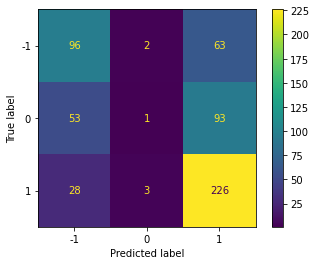

In [97]:
confusion_matrix(lr, skf, X_scaled, y)

### 2. Naive Bayes

In [98]:
nb = GaussianNB()

# set hyperparameter grid for optimisation
nb_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

In [99]:
%%time
nb_score = model_eval(nb, nb_grid, skf, X_scaled, y)

Cross-val F1-macro score: 0.429360752820385
var_smoothing: 0.003511191734215131

CPU times: user 423 ms, sys: 119 ms, total: 543 ms
Wall time: 729 ms


In [100]:
# implement tuned hyperparameters to model
nb = GaussianNB(
    var_smoothing=nb_score[1].get('var_smoothing')
)

              precision    recall  f1-score   support

          -1       0.52      0.65      0.58       161
           0       0.35      0.05      0.08       146
           1       0.60      0.80      0.69       257

    accuracy                           0.56       564
   macro avg       0.49      0.50      0.45       564
weighted avg       0.51      0.56      0.50       564



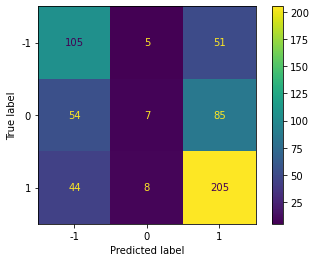

In [101]:
confusion_matrix(nb, skf, X_scaled, y)

### 3. Linear Discriminant Analysis (LDA)

In [102]:
lda = LDA()

# set hyperparameter grid for optimisation
lda_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': np.linspace(0, 1, num=11),
    'tol': np.logspace(0, -4, num=20)
}

In [103]:
%%time
lda_score = model_eval(lda, lda_grid, skf, X_scaled, y)

Cross-val F1-macro score: 0.42746316509084686
tol: 0.002976351441631319
solver: lsqr
shrinkage: 1.0

CPU times: user 559 ms, sys: 107 ms, total: 666 ms
Wall time: 1.7 s


In [104]:
# implement tuned hyperparameters to model
lda = LDA(
    solver=lda_score[1].get('solver'),
    shrinkage=lda_score[1].get('shrinkage'),
    tol=lda_score[1].get('tol')
)

              precision    recall  f1-score   support

          -1       0.48      0.66      0.56       161
           0       0.38      0.07      0.12       146
           1       0.62      0.77      0.69       257

    accuracy                           0.56       564
   macro avg       0.50      0.50      0.46       564
weighted avg       0.52      0.56      0.50       564



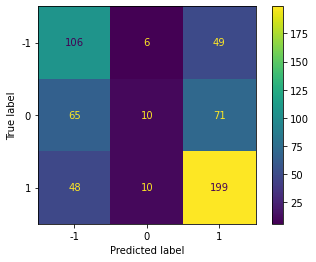

In [105]:
confusion_matrix(lda, skf, X_scaled, y)

### 4. Quadratic Discriminant Analysis (QDA)

In [106]:
qda = QDA()

# set hyperparameter grid for optimisation
qda_grid = {
    'tol': np.logspace(0, -4, num=100)
}

In [107]:
%%time
qda_score = model_eval(qda, qda_grid, skf, X_scaled, y)

Cross-val F1-macro score: 0.4400764386560688
tol: 1.0

CPU times: user 541 ms, sys: 179 ms, total: 719 ms
Wall time: 1.13 s


In [108]:
# implement tuned hyperparameters to model
qda = QDA(
    tol=qda_score[1].get('tol')
)

              precision    recall  f1-score   support

          -1       0.49      0.61      0.54       160
           0       0.33      0.12      0.17       147
           1       0.63      0.76      0.69       257

    accuracy                           0.55       564
   macro avg       0.48      0.50      0.47       564
weighted avg       0.51      0.55      0.51       564



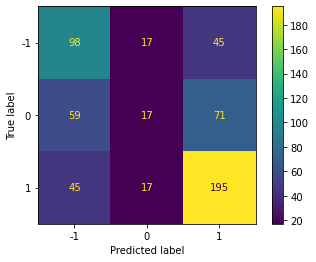

In [109]:
confusion_matrix(qda, skf, X_scaled, y)

### 5. Random Forest Classifier (RFC)

In [110]:
rfc = RandomForestClassifier()

# set hyperparameter grid for optimisation
rfc_grid = {
    'n_estimators': np.linspace(10, 50, num=11, dtype=int),
    'max_depth': np.linspace(10, 110, num = 6, dtype=int),
    'min_samples_split': np.linspace(2, 10, num = 6, dtype=int),
    'min_samples_leaf': np.linspace(1, 5, num = 6, dtype=int),
    'max_features': ['sqrt', 'log2', None]
}

In [111]:
%%time
rfc_score = model_eval(rfc, rfc_grid, skf, X_scaled, y)

Cross-val F1-macro score: 0.4530312273830196
n_estimators: 26
min_samples_split: 2
min_samples_leaf: 1
max_features: log2
max_depth: 70

CPU times: user 2.49 s, sys: 570 ms, total: 3.06 s
Wall time: 55.7 s


In [112]:
# implement tuned hyperparameters to model
rfc = RandomForestClassifier(
    n_estimators=rfc_score[1].get('n_estimators'),
    min_samples_split=rfc_score[1].get('min_samples_split'),
    min_samples_leaf=rfc_score[1].get('min_samples_leaf'),
    max_features=rfc_score[1].get('max_features'),
    max_depth=rfc_score[1].get('max_depth')
)

              precision    recall  f1-score   support

          -1       0.49      0.52      0.50       161
           0       0.19      0.11      0.14       147
           1       0.57      0.68      0.62       256

    accuracy                           0.49       564
   macro avg       0.42      0.44      0.42       564
weighted avg       0.45      0.49      0.46       564



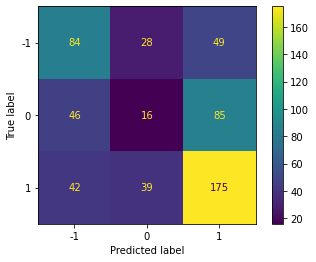

In [113]:
confusion_matrix(rfc, skf, X_scaled, y)

### 6. Decision Tree Classifier

In [114]:
dtc = DecisionTreeClassifier()

# set hyperparameter grid for optimisation
dtc_grid = {
    'max_depth': np.linspace(10, 110, num = 6, dtype=int),
    'min_samples_split': np.linspace(2, 10, num = 6, dtype=int),
    'min_samples_leaf': np.linspace(1, 5, num = 6, dtype=int),
    'max_features': ['sqrt', 'log2', None]
}

In [115]:
%%time
dtc_score = model_eval(dtc, dtc_grid, skf, X_scaled, y)

Cross-val F1-macro score: 0.4255451407667977
min_samples_split: 10
min_samples_leaf: 4
max_features: log2
max_depth: 10

CPU times: user 683 ms, sys: 118 ms, total: 801 ms
Wall time: 3.63 s


In [116]:
# implement tuned hyperparameters to model
dtc = DecisionTreeClassifier(
    min_samples_split=dtc_score[1].get('min_samples_split'),
    min_samples_leaf=dtc_score[1].get('min_samples_leaf'),
    max_features=dtc_score[1].get('max_features'),
    max_depth=dtc_score[1].get('max_depth')
)

              precision    recall  f1-score   support

          -1       0.43      0.59      0.50       161
           0       0.29      0.14      0.19       147
           1       0.57      0.61      0.59       256

    accuracy                           0.48       564
   macro avg       0.43      0.45      0.43       564
weighted avg       0.46      0.48      0.46       564



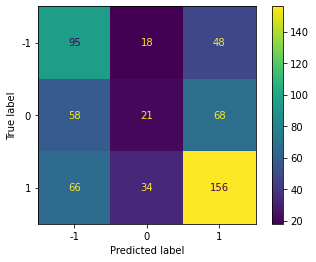

In [117]:
confusion_matrix(dtc, skf, X_scaled, y)

### 7. Adaptive Boosting Classifier

In [118]:
ada = AdaBoostClassifier(random_state=random_state)

# set hyperparameter grid for optimisation
ada_grid = {
    'base_estimator': [lr],
    'n_estimators': np.linspace(50, 100, num=11, dtype=int),
    'learning_rate': np.linspace(0.1, 2, num=11, dtype=float),
    'algorithm': ['SAMME']
}

In [119]:
%%time
ada_score = model_eval(ada, ada_grid, skf, X_scaled, y)

Cross-val F1-macro score: 0.4550455917968537
n_estimators: 85
learning_rate: 0.1
base_estimator: LogisticRegression(C=0.07847599703514622, max_iter=1000,
                   multi_class='multinomial',
                   random_state=RandomState(MT19937) at 0x7FCEF393F940,
                   solver='newton-cg')
algorithm: SAMME

CPU times: user 8.75 s, sys: 2.07 s, total: 10.8 s
Wall time: 2min 54s


In [120]:
# implement tuned hyperparameters to model
ada = AdaBoostClassifier(
    base_estimator=ada_score[1].get('base_estimator'),
    n_estimators=ada_score[1].get('n_estimators'),
    learning_rate=ada_score[1].get('learning_rate'),
    algorithm=ada_score[1].get('algorithm'),
    random_state=random_state
)

              precision    recall  f1-score   support

          -1       0.56      0.57      0.56       161
           0       0.34      0.15      0.21       147
           1       0.59      0.77      0.67       256

    accuracy                           0.55       564
   macro avg       0.50      0.50      0.48       564
weighted avg       0.52      0.55      0.52       564



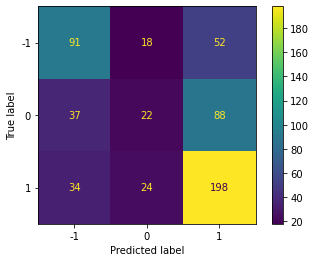

In [121]:
confusion_matrix(ada, skf, X_scaled, y)

### 8. Multi-Layer Perceptron (MLP)

In [122]:
mlp = MLPClassifier(max_iter=2000, random_state=random_state)

# set hyperparameter grid for optimisation
mlp_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': np.logspace(1, -4, num=10),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'hidden_layer_sizes': [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)]
}

In [123]:
%%time
mlp_score = model_eval(mlp, mlp_grid, skf, X_scaled, y)

Cross-val F1-macro score: 0.44207698458005107
solver: adam
learning_rate: adaptive
hidden_layer_sizes: (18,)
alpha: 0.0012915496650148827
activation: tanh

CPU times: user 35.1 s, sys: 8.12 s, total: 43.2 s
Wall time: 4min 29s


In [124]:
# implement tuned hyperparameters to model
mlp = MLPClassifier(
    max_iter=2000, 
    solver=mlp_score[1].get('solver'), 
    learning_rate=mlp_score[1].get('learning_rate'), 
    hidden_layer_sizes=mlp_score[1].get('hidden_layer_sizes'), 
    alpha=mlp_score[1].get('alpha'), 
    activation=mlp_score[1].get('activation'), 
    random_state=random_state
)

              precision    recall  f1-score   support

          -1       0.56      0.56      0.56       161
           0       0.19      0.06      0.09       147
           1       0.58      0.81      0.67       257

    accuracy                           0.54       565
   macro avg       0.44      0.48      0.44       565
weighted avg       0.47      0.54      0.49       565



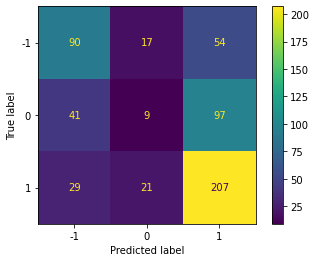

In [125]:
confusion_matrix(mlp, skf, X_scaled, y)

# Part 6 - Results

### Comparing model performance

,LR,NB,LDA,QDA,RFC,DTC,ADA,MLP
0,0.4087,0.4294,0.4275,0.4401,0.4530,0.4255,0.4550,0.4421


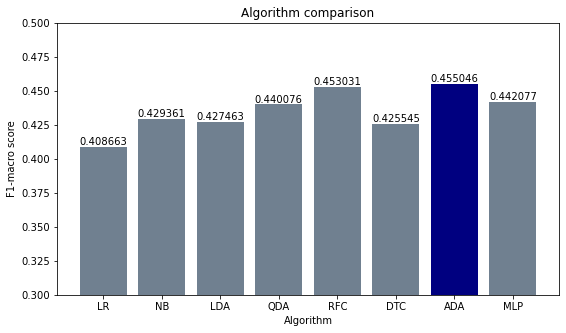

In [139]:
results = { 
    'LR': lr_score[0],
    'NB': nb_score[0],
    'LDA': lda_score[0],
    'QDA': qda_score[0],
    'RFC': rfc_score[0],
    'DTC': dtc_score[0],
    'ADA': ada_score[0],
    'MLP': mlp_score[0]
}

models = list(results.keys())
scores = list(results.values())

# maximum accuracy will show in navy for more clarity
max_index = scores.index(max(scores))
colours = []
for model in results.keys():
    colours.append('slategrey')
colours[max_index] = 'navy'

plt.figure(figsize=(9, 5))
ax = plt.bar(
    range(len(models)),
    scores,
    tick_label=models,
    color=colours,
)
plt.title('Algorithm comparison')
plt.xlabel('Algorithm')
plt.ylabel('F1-macro score')
plt.ylim(0.3, 0.5)
plt.bar_label(ax)

results = pd.DataFrame(data=results, index=[0])
results

Hence the best performing model is Adaptive Boosting Classifier using Logistic Regression.

# Part 7 - Final Predictions on Test Set

In [127]:
# scale data
X_test = scaler.transform(test_data)

In [128]:
y_test = ada.predict(X_test)

              precision    recall  f1-score   support

          -1       0.48      0.42      0.45        65
           0       0.34      0.23      0.28        64
           1       0.62      0.77      0.69       118

    accuracy                           0.54       247
   macro avg       0.48      0.47      0.47       247
weighted avg       0.51      0.54      0.52       247

Test F1-score (macro avg): 0.4702837407811679


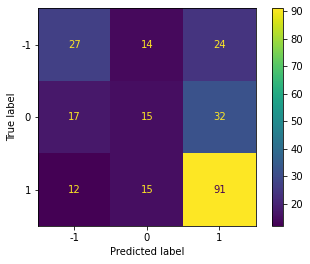

In [129]:
ada.fit(X_scaled, y)
y_test = ada.predict(X_test)

print(classification_report(y_test_actual, y_test, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_test_actual, y_test);

cr_dict = classification_report(y_test_actual, y_test, zero_division=0, output_dict=True)
f1_test = cr_dict.get('macro avg').get('f1-score')

print(f"Test F1-score (macro avg): {f1_test}")

### Baseline model

In order to evaluate model performance, we compare it against a baseline model.

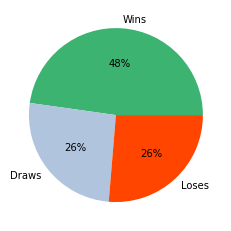

In [130]:
counts = np.array([118, 64, 65])
categories = ['Wins', 'Draws', 'Loses']

plt.pie(
    counts,
    labels=categories,
    colors=['mediumseagreen', 'lightsteelblue', 'orangered'],
    autopct='%.0f%%'
)

plt.show() 

Since the mayority of games result in a home win, we set our baseline as always predicting a home win.

To calculate the F1-score (macro avg) we calculate the f1-score for each of the labes and average them out.

In [131]:
true_pos_win = 118
false_pos_win = 64 + 65
false_neg_win = 0

precision_win = true_pos_win / (true_pos_win+false_pos_win)
recall_win = true_pos_win / (true_pos_win+false_neg_win)
f1_base_win = 2 * (precision_win*recall_win) / (precision_win+recall_win)

# We know true_pos for lose and draw is zero, because we never predict
# Thus, recall and precision are also zero, and so is their F1-score
f1_base_lose = 0
f1_base_draw = 0

f1_base = mean([f1_base_win, f1_base_lose, f1_base_draw])

print(f'Baseline F1-score (macro avg): {f1_base}')

Baseline F1-score (macro avg): 0.21552511415525114


In [132]:
# Printing results
print(f"Test F1-score (macro avg): {f1_test}")
print(f'Baseline F1-score (macro avg): {f1_base}')
print(f'Performance increase: {100*(f1_test-f1_base)/f1_base} %')

Test F1-score (macro avg): 0.4702837407811679
Baseline F1-score (macro avg): 0.21552511415525114
Performance increase: 118.2036848116012 %


### ROC Curve
A Receiver Operating Characteristic curve (ROC curve) is a graphical plot of the true positive rate (TPR) against the false positive rate (FPR), using different threshold settings.

In [133]:
# binarise output
y_bin = label_binarize(y, classes=[-1, 0, 1])
y_test_bin = label_binarize(y_test_actual, classes=[-1, 0, 1])

# learn to predict each class against the other, using MLP which was the most accurate model
classifier = OneVsRestClassifier(lda)
y_score = classifier.fit(X, y_bin).predict_proba(X_test)

# compute ROC curve and area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/Users/rafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/Users/rafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/Users/rafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


We now proceed to compute and plot the micro and macro averages.

In [134]:
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<Figure size 432x288 with 0 Axes>

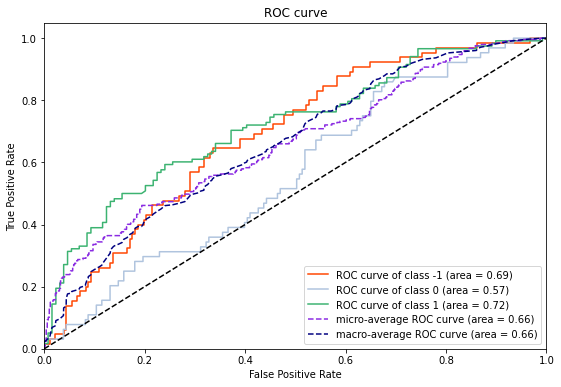

In [135]:
# plotting results   
plt.figure()
plt.figure(figsize=(9, 6))

# curves for each class
plt.plot(
    fpr[0],
    tpr[0],
    color='orangered',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(-1, roc_auc[0]),
)
plt.plot(
    fpr[1],
    tpr[1],
    color='lightsteelblue',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(0, roc_auc[1]),
)
plt.plot(
    fpr[2],
    tpr[2],
    color='mediumseagreen',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(1, roc_auc[2]),
)

# curves for micro and macro averages
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="blueviolet",
    linestyle="--",
)
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle="--",
)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

## Predicting World Cup results

We now apply the model tested to the 2022 Qatar World Cup dataset to predict the results of the tournament.

In [136]:
# scale data
X_pred = scaler.transform(pred_data)

In [137]:
y_pred_outcome = ada.predict(X_pred)
y_pred_proba = ada.predict_proba(X_pred)

In [138]:
# we now take a look at the match probabilities and output
pred_output = pred_output.assign(home_team_result=y_pred_outcome)
pred_output['home_team_result'] = pred_output['home_team_result'].map({1:'Win', 0:'Draw', -1:'Lose'})

pred_output = pred_output.assign(win_probability=[i[2] for i in y_pred_proba])
pred_output = pred_output.assign(draw_probability=[i[1] for i in y_pred_proba])
pred_output = pred_output.assign(lose_probability=[i[0] for i in y_pred_proba])

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pred_output

,date,home_team,away_team,home_team_result,win_probability,draw_probability,lose_probability
0,2022-11-20,Qatar,Ecuador,Win,0.3621,0.3576,0.2803
1,2022-11-21,Senegal,Netherlands,Lose,0.3380,0.2844,0.3776
2,2022-11-21,England,IR Iran,Win,0.4519,0.2741,0.2741
3,2022-11-21,USA,Wales,Win,0.3621,0.3576,0.2803
4,2022-11-22,France,Australia,Win,0.4519,0.2741,0.2741
5,2022-11-22,Denmark,Tunisia,Win,0.4465,0.2788,0.2748
6,2022-11-22,Mexico,Poland,Draw,0.3547,0.3582,0.2871
7,2022-11-22,Argentina,Saudi Arabia,Win,0.4519,0.2741,0.2741
8,2022-11-23,Belgium,Canada,Win,0.4519,0.2741,0.2741
9,2022-11-23,Spain,Costa Rica,Win,0.4519,0.2741,0.2741


# [END PROJECT]